<div class="alert alert-info">
My notebook for muon $p_{\mathrm{T}}$ regression.
</div>

In [1]:
from nn_globals import *

from nn_encode import (nlayers, nvariables, create_encoder)

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, reduce_lr)

from nn_training import train_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


### Parameters

In [2]:
# Train a new model or use an existing model
do_training = False

# Specify inputs for the training
# - default: muon gun with a uniform distribution in 1/pT, eta, phi (pT>2, 1.2<|eta|<2.5)
# - run2   : default minus Phase-2 trigger primitives
# - omtf   : muon gun in the overlap region (pT>3, 0.8<|eta|<1.4)
# - displ  : displaced muons with 0<|d0|<120 cm
# - mixing : tracks from MinBias PU200 events
# - collus : tracks from SingleMu+PU200 events
run2_input = False

omtf_input = False

displ_input = True

mixing_input = True

collus_input = True

# Training parameters
model_name = 'model15'

nodes = [30,25,20]

learning_rate = 0.01

epochs = 300

batch_size = 2048

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import (nlayers, nvariables, create_encoder)
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450

In [3]:
#FIXME
infile_pileup = '../test7/histos_tbd_alt.27.npz'

In [4]:
#FIXME
from nn_models import (Sequential, Dense, BatchNormalization, Activation,
                       regularizers, optimizers)

from tensorflow.python.ops.distributions import special_math

def hexa_loss(y_true, y_pred, reg_pt_scale=100., reg_dxy_scale=0.4):
  t = y_pred
  u = y_true

  _ones = K.ones_like(t[..., 0:1], dtype=K.floatx())

  def _cast(x):
    return K.cast(x, dtype=K.floatx())

  def _log_prob(x, loc, scale, low, high, weight=1.0):
    # Log probability for Truncated Gaussian, see:
    #   https://en.wikipedia.org/wiki/Truncated_normal_distribution
    #   https://github.com/tensorflow/probability/blob/v0.6.0/tensorflow_probability/python/distributions/truncated_normal.py
    standardize = lambda x: (x - loc) / scale
    x = tf.clip_by_value(x, low, high)
    tiny = np.float32(1e-15)
    eps = np.finfo(np.float32).eps
    log_prob_normalizer = (special_math.ndtr(standardize(high)) -
                           special_math.ndtr(standardize(low)))
    log_prob_normalizer = tf.clip_by_value(log_prob_normalizer, tiny, 1. - eps)
    log_prob = -(0.5 * K.square(standardize(x)) +
                 0.5 * np.log(2. * np.pi) +
                 K.log(scale * log_prob_normalizer))
    log_prob *= weight
    return log_prob

  def _log_prob_bce(labels, logits, weight=1.0):
    log_prob_bce = -tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    log_prob_bce *= weight
    return log_prob_bce

  def _huber_loss(y_true, y_pred, delta=1.345, weight=1.0):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5 * K.square(x)
    absolute_loss = delta * (x - 0.5 * delta)
    loss = tf.where(x < delta, squared_loss, absolute_loss)
    loss *= -1
    loss *= weight
    return loss

  # Classes
  masks_prompt = K.equal(u[..., 3:4], MASKS.prompt)
  masks_displ = K.equal(u[..., 3:4], MASKS.displ)
  masks_pileup = K.equal(u[..., 3:4], MASKS.pileup)
  masks_pileupx = K.equal(u[..., 3:4], MASKS.pileupx)

  # Regr 0: vertex-constrained pT
  y_true0 = u[..., 0:1]
  y_pred0 = t[..., 0:1]

  # Regr 1: vertex-unconstrained pT
  y_true1 = u[..., 1:2]
  y_pred1 = t[..., 1:2]

  # Regr 2: transverse impact parameter d0
  y_true2 = u[..., 2:3]
  y_pred2 = t[..., 2:3]

  # Discr 0: vertex-constrained pT > 4 GeV as signal
  labels0 = K.less(K.abs(y_true0), (1.0/discr_pt_cut_low) * reg_pt_scale)  # less than 1/4 in [1/GeV]
  labels0 &= ~masks_pileupx  # AND NOT pileupx
  labels0 = _cast(labels0)
  logits0 = t[..., 3:4]

  # Discr 1: vertex-constrained pT > 8 GeV as signal
  labels1 = K.less(K.abs(y_true0), (1.0/discr_pt_cut_med) * reg_pt_scale)  # less than 1/8 in [1/GeV]
  labels1 &= ~masks_pileupx  # AND NOT pileupx
  labels1 = _cast(labels1)
  logits1 = t[..., 4:5]

  # Discr 2: vertex-unconstrained pT > 14 GeV as signal
  labels2 = K.less(K.abs(y_true1), (1.0/discr_pt_cut_high) * reg_pt_scale) # less than 1/14 in [1/GeV]
  labels2 &= ~masks_pileupx  # AND NOT pileupx
  labels2 = _cast(labels2)
  logits2 = t[..., 5:6]

  # Log probs
  masks0 = _cast(masks_prompt)
  log_prob0 = _huber_loss(y_true0, y_pred0, weight=1.0) * masks0
  log_prob0 /= (K.mean(masks0) + K.epsilon())

  masks1 = _cast(masks_displ)
  log_prob1 = _huber_loss(y_true1, y_pred1, weight=0.5) * masks1
  log_prob1 /= (K.mean(masks1) + K.epsilon())

  masks2 = _cast(masks_displ)
  log_prob2 = _huber_loss(y_true2, y_pred2, weight=0.5) * masks2
  log_prob2 /= (K.mean(masks2) + K.epsilon())

  masks_discr0 = _cast(masks_prompt | masks_pileup | masks_pileupx)
  log_prob_discr0 = _log_prob_bce(labels0, logits0, weight=20.0) * masks_discr0
  log_prob_discr0 /= (K.mean(masks_discr0) + K.epsilon())

  masks_discr1 = _cast(masks_prompt | masks_pileup | masks_pileupx)
  log_prob_discr1 = _log_prob_bce(labels1, logits1, weight=20.0) * masks_discr1
  log_prob_discr1 /= (K.mean(masks_discr1) + K.epsilon())

  masks_discr2 = _cast(masks_displ | masks_pileup | masks_pileupx)
  log_prob_discr2 = _log_prob_bce(labels2, logits2, weight=20.0) * masks_discr2
  log_prob_discr2 /= (K.mean(masks_discr2) + K.epsilon())

  # Loss
  #loss = -log_prob0
  #loss = -log_prob1
  #loss = -log_prob2
  #loss = -log_prob_discr0
  #loss = -log_prob_discr1
  #loss = -log_prob_discr2
  loss = -(log_prob0 + log_prob1 + log_prob2 + 
           log_prob_discr0 + log_prob_discr1 + log_prob_discr2)
  return K.mean(loss, axis=-1)

def create_model_sequential_gaus(nodesIn=36, nodesOut=1, nodes1=30, nodes2=25, nodes3=20, loss=None):
  '''Create a Sequential model for a dense NN with 3 hidden layers.'''

  model = Sequential([
    # BN layer right after the input layer
    BatchNormalization(input_shape=(nodesIn,), epsilon=1e-4, momentum=0.9),
    # Hidden layer 1
    Dense(nodes1, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Hidden layer 2
    Dense(nodes2, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Hidden layer 3
    Dense(nodes3, kernel_initializer='glorot_uniform', use_bias=False, activation=None),
    BatchNormalization(epsilon=1e-4, momentum=0.9),
    Activation('relu'),
    # Output layer
    Dense(nodesOut, kernel_initializer='zeros', use_bias=True, activation=None),
  ])

  # Set loss and optimizer
  adam = optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=adam, loss=loss)
  return model

In [5]:
# Freeze some function keywords
from functools import partial

create_encoder_1 = partial(create_encoder,
                           reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)

hexa_loss_1 = partial(hexa_loss,
                      reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
hexa_loss_1.__name__ = hexa_loss.__name__  # needed for Keras save_model()

create_model_1 = partial(create_model_sequential_gaus,
                         nodesIn=nvariables, nodesOut=6, loss=hexa_loss_1)

train_model_1 = partial(train_model,
                        model_name=model_name, callbacks=[lr_decay,], verbose=1)

### Import data

In [6]:
# Import muon data
# 'x' is the array of input variables, 'y' is muon q/pT

test_size = 0.3

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, create_encoder=create_encoder_1, test_size=test_size, no_warn=False)

[INFO    ] Loading muon data from ../test7/histos_tba.27.npz ...
[INFO    ] Loaded the variables with shape (3319149, 164)
[INFO    ] Loaded the parameters with shape (3319149, 6)
[INFO    ] Loaded the encoded variables with shape (3319149, 36)
[INFO    ] Loaded the encoded parameters with shape (3319149,)
[INFO    ] Loaded # of training and testing events: (2323404, 995745)


In [7]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_y_train, pu_y_test, pu_dxy_train, pu_dxy_test, pu_dz_train, pu_dz_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test, pu_aux_train, pu_aux_test = \
    pileup_data_split(infile_pileup, create_encoder=create_encoder_1, test_job=test_job)

[INFO    ] Loading pileup data from ../test7/histos_tbd_alt.27.npz ...
[INFO    ] Loaded the variables with shape (2393487, 164)
[INFO    ] Loaded the auxiliary PU info with shape (2393487, 4)
[INFO    ] Loaded the encoded variables with shape (2393487, 36)
[INFO    ] Loaded the encoded parameters with shape (2393487,)
[INFO    ] Loaded the encoded auxiliary PU info with shape (2393487, 4)
[INFO    ] Loaded # of training and testing events (PU): (2202595, 190892)


In [8]:
# Import highpt data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

highpt_x_train, highpt_x_test, highpt_y_train, highpt_y_test, highpt_dxy_train, highpt_dxy_test, highpt_dz_train, highpt_dz_test, highpt_x_mask_train, highpt_x_mask_test, highpt_x_road_train, highpt_x_road_test = \
    muon_data_split(infile_highpt, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tbe.27.npz ...
[INFO    ] Loaded the variables with shape (215816, 164)
[INFO    ] Loaded the parameters with shape (215816, 6)
[INFO    ] Loaded the encoded variables with shape (215816, 36)
[INFO    ] Loaded the encoded parameters with shape (215816,)
[INFO    ] Loaded # of training and testing events: (151071, 64745)


In [9]:
# Import displ muon data (1)
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

displ1_x_train, displ1_x_test, displ1_y_train, displ1_y_test, displ1_dxy_train, displ1_dxy_test, displ1_dz_train, displ1_dz_test, displ1_x_mask_train, displ1_x_mask_test, displ1_x_road_train, displ1_x_road_test = \
    muon_data_split(infile_displ1, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tba_displ1.27.npz ...
[INFO    ] Loaded the variables with shape (1105260, 164)
[INFO    ] Loaded the parameters with shape (1105260, 6)
[INFO    ] Loaded the encoded variables with shape (1105260, 36)
[INFO    ] Loaded the encoded parameters with shape (1105260,)
[INFO    ] Loaded # of training and testing events: (773682, 331578)


In [10]:
# Import displ muon data (2)
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.3

displ2_x_train, displ2_x_test, displ2_y_train, displ2_y_test, displ2_dxy_train, displ2_dxy_test, displ2_dz_train, displ2_dz_test, displ2_x_mask_train, displ2_x_mask_test, displ2_x_road_train, displ2_x_road_test = \
    muon_data_split(infile_displ2, create_encoder=create_encoder_1, test_size=test_size, no_warn=True)

[INFO    ] Loading muon data from ../test7/histos_tba_displ2.27.npz ...
[INFO    ] Loaded the variables with shape (969134, 164)
[INFO    ] Loaded the parameters with shape (969134, 6)
[INFO    ] Loaded the encoded variables with shape (969134, 36)
[INFO    ] Loaded the encoded parameters with shape (969134,)
[INFO    ] Loaded # of training and testing events: (678393, 290741)


In [11]:
#FIXME
# Take absolute values

y_train = np.abs(y_train)
y_test = np.abs(y_test)
pu_y_train = np.abs(pu_y_train)
pu_y_test = np.abs(pu_y_test)
highpt_y_train = np.abs(highpt_y_train)
highpt_y_test = np.abs(highpt_y_test)
displ1_y_train = np.abs(displ1_y_train)
displ1_y_test = np.abs(displ1_y_test)
displ2_y_train = np.abs(displ2_y_train)
displ2_y_test = np.abs(displ2_y_test)

In [12]:
# Add 'classes' output node, and join all the output nodes

class Masks:
  '''Dummy class'''
  pass

def define_mask_values():
  '''Define mask values for classes

  90 - Prompt muons
  80 - Displaced muons
  20 - PU tracks with matched TP
  10 - PU tracks without matched TP
   0 - default
  '''
  MASKS = Masks()
  MASKS.prompt = 90
  MASKS.displ = 80
  MASKS.pileup = 20
  MASKS.pileupx = 10
  return MASKS

MASKS = define_mask_values()

if do_training:
  y_train_tmp = np.full(y_train.shape, MASKS.prompt, dtype=np.float32)
  y_train_tmp = np.column_stack((y_train, y_train, dxy_train, y_train_tmp))

  pu_y_train_tmp = np.full(pu_y_train.shape, MASKS.pileup, dtype=np.float32)
  pu_y_train_tmp[(pu_y_train == 0) | (np.abs(pu_y_train) > 0.5 * reg_pt_scale)] = MASKS.pileupx
  pu_y_train_tmp[(np.abs(pu_dxy_train) > 3. * reg_dxy_scale)] = MASKS.pileupx
  pu_y_train_tmp = np.column_stack((pu_y_train, pu_y_train, pu_dxy_train, pu_y_train_tmp))

  highpt_y_train_tmp = np.full(highpt_y_train.shape, MASKS.prompt, dtype=np.float32)
  highpt_y_train_tmp = np.column_stack((highpt_y_train, highpt_y_train, highpt_dxy_train, highpt_y_train_tmp))

  displ1_y_train_tmp = np.full(displ1_y_train.shape, MASKS.displ, dtype=np.float32)
  displ1_y_train_tmp = np.column_stack((displ1_y_train, displ1_y_train, displ1_dxy_train, displ1_y_train_tmp))

  displ2_y_train_tmp = np.full(displ2_y_train.shape, MASKS.displ, dtype=np.float32)
  displ2_y_train_tmp = np.column_stack((displ2_y_train, displ2_y_train, displ2_dxy_train, displ2_y_train_tmp))

  logger.info('Dataset 0: {0} class: {1}'.format((x_train.shape, y_train_tmp.shape), np.squeeze(y_train_tmp[..., 3:4])))
  logger.info('Dataset 1: {0} class: {1}'.format((pu_x_train.shape, pu_y_train_tmp.shape), np.squeeze(pu_y_train_tmp[..., 3:4])))
  logger.info('Dataset 2: {0} class: {1}'.format((highpt_x_train.shape, highpt_y_train_tmp.shape), np.squeeze(highpt_y_train_tmp[..., 3:4])))
  logger.info('Dataset 3: {0} class: {1}'.format((displ1_x_train.shape, displ1_y_train_tmp.shape), np.squeeze(displ1_y_train_tmp[..., 3:4])))
  logger.info('Dataset 4: {0} class: {1}'.format((displ2_x_train.shape, displ2_y_train_tmp.shape), np.squeeze(displ2_y_train_tmp[..., 3:4])))

In [13]:
# Merge the final training data, and prepare validation data

validation_split = 0.1

def training_slice(x):
  split_at = int(int(x.shape[0]) * (1. - validation_split))
  return x[0:split_at]

def validation_slice(x):
  split_at = int(int(x.shape[0]) * (1. - validation_split))
  return x[split_at:]

def _128_slice(x):
  split_at = x.shape[0] - (x.shape[0] % 128)
  return x[0:split_at]

if do_training:
  x_train_new = np.concatenate((
      training_slice(x_train),
      training_slice(pu_x_train),  # artificially increase PU stats
      training_slice(pu_x_train),  # artificially increase PU stats
      #training_slice(pu_x_train),  # artificially increase PU stats
      #training_slice(pu_x_train),  # artificially increase PU stats
      training_slice(highpt_x_train),
      training_slice(displ1_x_train),
      training_slice(displ2_x_train),
  ))
  x_train_new = _128_slice(x_train_new)

  y_train_new = np.concatenate((
      training_slice(y_train_tmp),
      training_slice(pu_y_train_tmp),  # artificially increase PU stats
      training_slice(pu_y_train_tmp),  # artificially increase PU stats
      #training_slice(pu_y_train_tmp),  # artificially increase PU stats
      #training_slice(pu_y_train_tmp),  # artificially increase PU stats
      training_slice(highpt_y_train_tmp),
      training_slice(displ1_y_train_tmp),
      training_slice(displ2_y_train_tmp),
  ))
  y_train_new = _128_slice(y_train_new)

  val_x_train_new = np.concatenate((
      validation_slice(x_train),
      validation_slice(pu_x_train),  # artificially increase PU stats
      validation_slice(pu_x_train),  # artificially increase PU stats
      #validation_slice(pu_x_train),  # artificially increase PU stats
      #validation_slice(pu_x_train),  # artificially increase PU stats
      validation_slice(highpt_x_train),
      validation_slice(displ1_x_train),
      validation_slice(displ2_x_train),
  ))
  val_x_train_new = _128_slice(val_x_train_new)

  val_y_train_new = np.concatenate((
      validation_slice(y_train_tmp),
      validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      #validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      #validation_slice(pu_y_train_tmp),  # artificially increase PU stats
      validation_slice(highpt_y_train_tmp),
      validation_slice(displ1_y_train_tmp),
      validation_slice(displ2_y_train_tmp),
  ))
  val_y_train_new = _128_slice(val_y_train_new)

  # Shuffle validation data
  num_val_samples = val_x_train_new.shape[0]
  val_index_array = np.arange(num_val_samples)
  np.random.shuffle(val_index_array)
  val_x_train_new = val_x_train_new[val_index_array]
  val_y_train_new = val_y_train_new[val_index_array]

  logger.info('Final dataset: {0} validation: {1}'.format((x_train_new.shape, y_train_new.shape), (val_x_train_new.shape, val_y_train_new.shape)))

### Training

In [14]:
# Fit

if do_training:
  assert(K.backend() == 'tensorflow')
  model = create_model_1(nodes1=nodes[0], nodes2=nodes[1], nodes3=nodes[2])
  model.summary()

  ## Start training
  #history = model.fit(displ2_x_train, displ2_y_train_tmp,
  #                    validation_split=validation_split,
  #                    callbacks=[reduce_lr,],
  #                    epochs=epochs, batch_size=batch_size, verbose=1)
  #from nn_models import save_my_model
  #save_my_model(model, name=model_name)

  # Start training
  history = model.fit(x_train_new, y_train_new,
                      validation_data=(val_x_train_new, val_y_train_new),
                      callbacks=[reduce_lr,],
                      epochs=epochs, batch_size=batch_size, verbose=1)
  from nn_models import save_my_model
  save_my_model(model, name=model_name)

  ## Start training
  #history = train_model_1(model, x_train, y_train, validation_data=(val_x_train_new, val_y_train_new),
  #                        epochs=epochs, batch_size=batch_size)
  #metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
  #logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

In [15]:
# Plot loss vs epoch

if do_training:
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.ylim(2,20)
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [16]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)
my_palette = ('#377eb8', '#e41a1c', '#984ea3', '#ff7f00', '#4daf4a', '#bfbf33', '#a65628', '#f781bf')

In [17]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
loaded_model = load_my_model(name=model_name+'.json', weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

def np_relu(x):
  # ReLu(x) = max(0, x)
  return x * (x >= 0.)

def np_softplus(x):
  # Softplus f(x) = log(1+exp(x))
  return np_relu(x) + np.log1p(np.exp(-np.abs(x)))

def np_sigmoid(x):
  # Sigmoid f(x) = 1/(1+exp(-x))
  # It is related to tanh, which is safer to call.
  return 0.5 * (1. + np.tanh(0.5*x))

def np_normal_cdf(x):
  return 0.5 * (1. + scipy.special.erf(x/np.sqrt(2.)))

def get_discr(x):
  prob = np_sigmoid(x)
  return prob

def get_true_pt(x):
  out = x.copy()
  out /= reg_pt_scale
  if out.ndim == 1:
    out = out[:, np.newaxis]
  return out

def get_true_dxy(x):
  out = x.copy()
  out /= reg_dxy_scale
  if out.ndim == 1:
    out = out[:, np.newaxis]
  return out

def get_regr_pt(x):
  out = x
  out /= reg_pt_scale
  return out

def get_regr_dxy(x):
  out = x
  out /= reg_dxy_scale
  return out

In [18]:
# Prepare y_test_true, y_test_pred
y_test_true = get_true_pt(y_test[:nentries_test])
y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
y_test_pred_regr = get_regr_pt(y_test_pred[..., 0:1])
y_test_pred_discr = get_discr(y_test_pred[..., 3:4])
y_test_pred_discr1 = get_discr(y_test_pred[..., 4:5])
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

In [19]:
# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_true = get_true_pt(pu_y_test)
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
pu_y_test_pred_regr = get_regr_pt(pu_y_test_pred[..., 0:1])
pu_y_test_pred_discr = get_discr(pu_y_test_pred[..., 3:4])
pu_y_test_pred_discr1 = get_discr(pu_y_test_pred[..., 4:5])
#print pu_y_test_true.shape, pu_y_test_true
#print pu_y_test_pred.shape, pu_y_test_pred

[INFO    ] # of entries: 124468, mean: -3.119275e-03, std: 3.695848e-02, mse: 1.406952e-03, mae: 2.522141e-02, mad: 2.471147e-02
[INFO    ] gaus fit (a, mu, sig): 9.940749e+03, -4.238637e-04, 2.207985e-02
[INFO    ] # of entries: 20086, mean: 4.704804e-03, std: 1.468453e-02, mse: 5.947835e-04, mae: 1.171861e-02, mad: 1.032468e-02
[INFO    ] gaus fit (a, mu, sig): 1.289631e+03, 1.050659e-03, 9.463448e-03
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


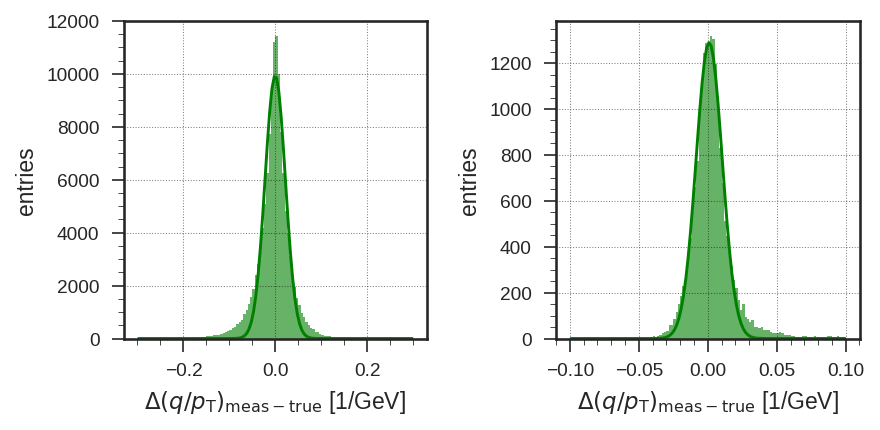

In [20]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 124468, mean: 2.567422e-02, std: 1.218604e-01, mse: 8.243737e-02, mae: 1.577856e-01, mad: 1.426397e-01
[INFO    ] gaus fit (a, mu, sig): 8.723676e+03, 4.591997e-04, 1.267403e-01
[INFO    ] # of entries: 20086, mean: -2.064570e-02, std: 1.528156e-01, mse: 2.621942e-01, mae: 3.302842e-01, mad: 3.221661e-01
[INFO    ] gaus fit (a, mu, sig): 6.278066e+02, -4.834742e-02, 2.750933e-01


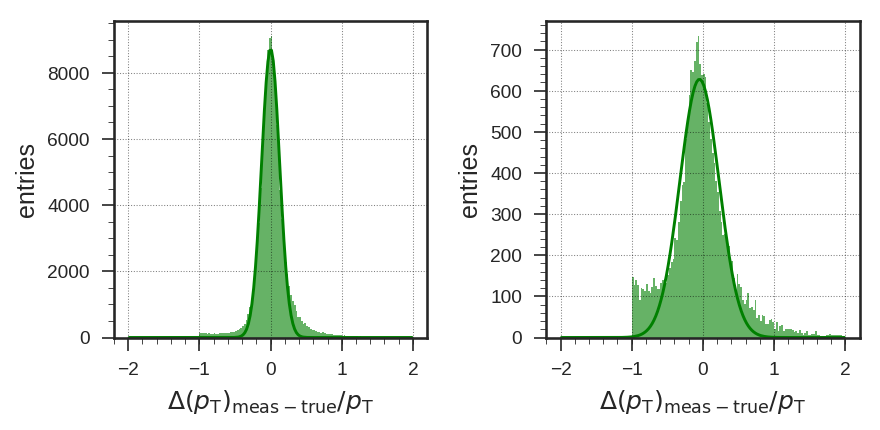

In [21]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred_regr)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

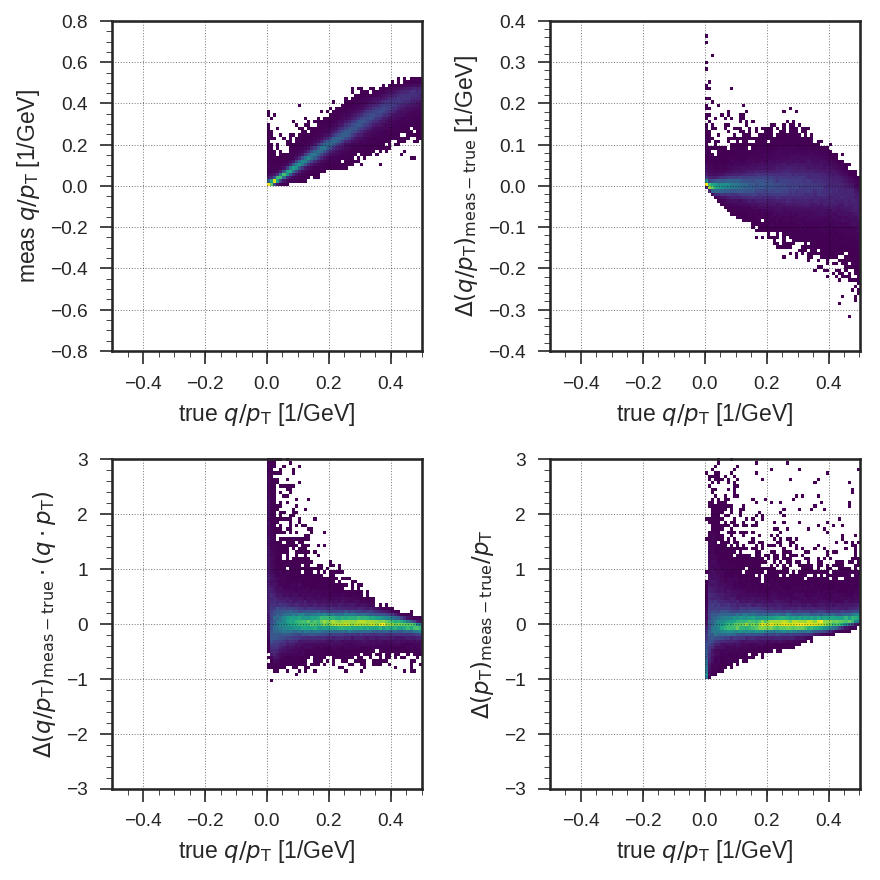

In [22]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV]')

yy = y_test_pred_regr - y_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,1].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')

yy = (y_test_pred_regr - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,0].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}} \cdot (q \cdot p_{\mathrm{T}})$')

yy = np.abs(y_test_true/y_test_pred_regr) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,1].set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')

plt.show()

In [23]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = np.abs(y_test_true/y_test_pred_regr) - 1
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 7.610915e+01, -3.774577e-02, 1.599417e-01
[INFO    ] gaus fit (a, mu, sig): 5.852799e+01, -2.515498e-02, 2.137155e-01
[INFO    ] gaus fit (a, mu, sig): 5.291023e+01, -4.212519e-02, 2.248660e-01


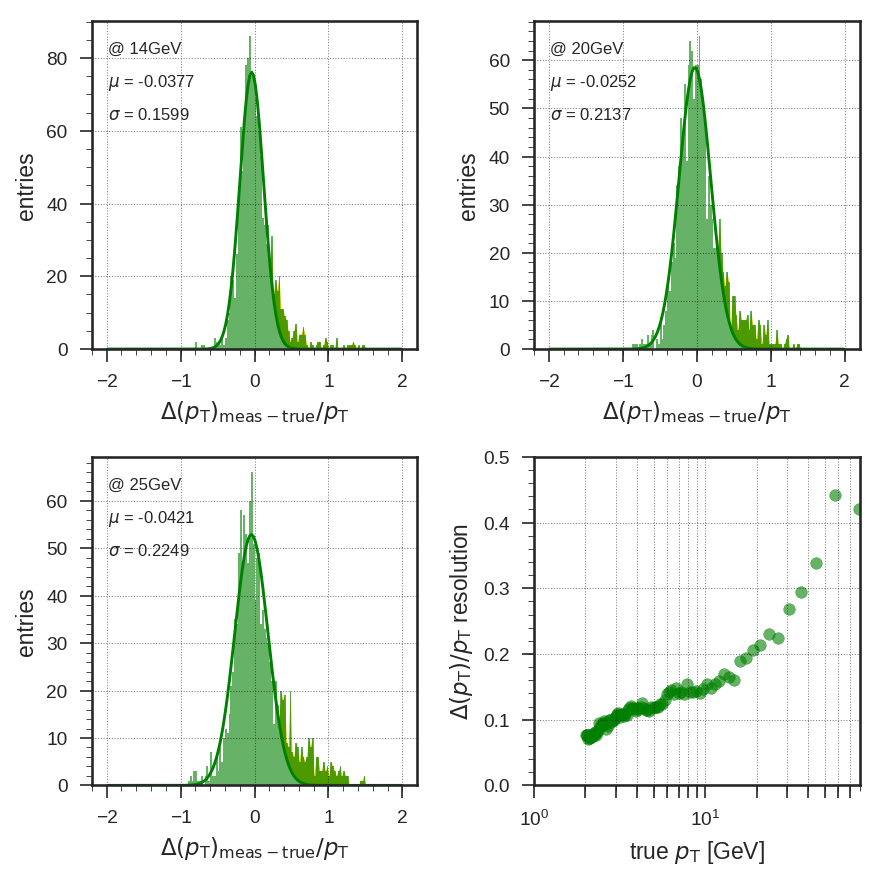

In [24]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

[INFO    ] high tail prob: 1.124194e-01, 1.175995e-01, 1.499750e-01


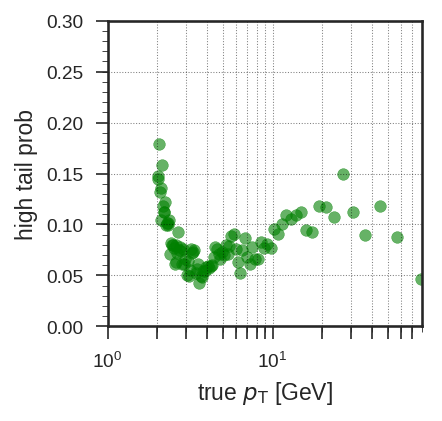

In [25]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'high tail prob')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

[INFO    ] coverage # of sigmas: 1.336238e+00, 1.256449e+00, 1.276965e+00


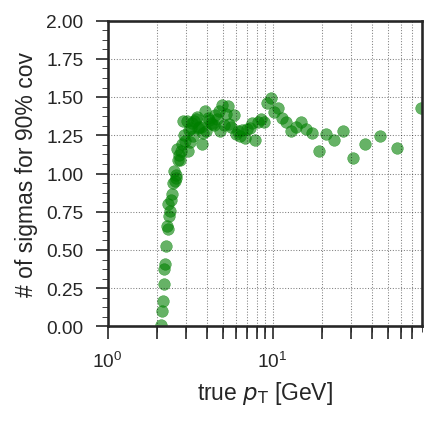

In [26]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'# of sigmas for 90% cov')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

### Classification Results (1)

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (80628, 20086), ll: 0.286838116101, ss: 0.93246890934
[INFO    ] (180, 18121), auc: 0.917951088056
[INFO    ] thr: [0.9976, 0.9967, 0.9951, 0.9926, 0.9912, 0.9900, 0.9879, 0.9834, 0.9072]
[INFO    ] tpr: [0.9007, 0.9259, 0.9500, 0.9700, 0.9762, 0.9807, 0.9860, 0.9918, 0.9990]
[INFO    ] fpr: [0.2278, 0.2389, 0.2667, 0.3056, 0.3278, 0.3500, 0.3833, 0.4167, 0.6111]


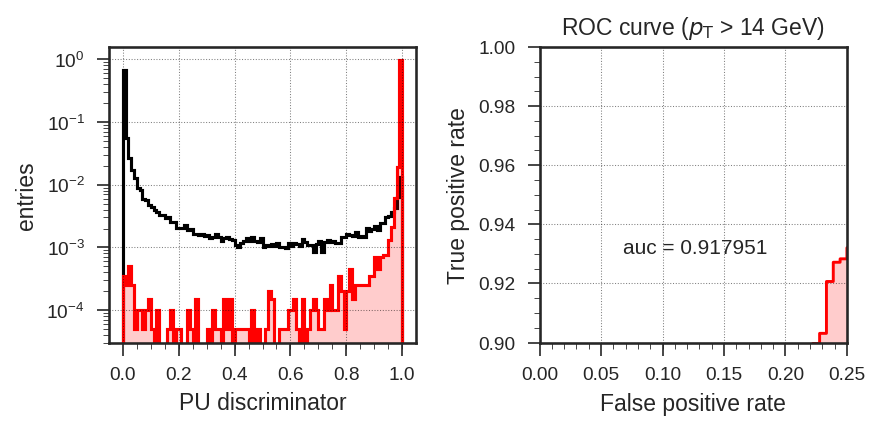

In [27]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
y_test_sel_high = np.abs(1.0/y_test_true) > discr_pt_cut_high
pu_y_test_sel_high = np.abs(1.0/pu_y_test_true) < discr_pt_cut_high

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_high], np.zeros_like(pu_y_test_true)[pu_y_test_sel_high]))
yy = np.concatenate((y_test_pred_discr[y_test_sel_high], pu_y_test_pred_discr[pu_y_test_sel_high]))
zz = np.concatenate((y_test_pred_regr[y_test_sel_high], pu_y_test_pred_regr[pu_y_test_sel_high]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_high)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.25)
axs[1].set_ylim(0.9,1.0)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (79866, 35286), ll: 0.243911555569, ss: 0.929627205297
[INFO    ] (613, 32726), auc: 0.917316790886
[INFO    ] thr: [0.9948, 0.9928, 0.9899, 0.9850, 0.9834, 0.9803, 0.9769, 0.9705, 0.7701]
[INFO    ] tpr: [0.9000, 0.9264, 0.9502, 0.9710, 0.9752, 0.9809, 0.9851, 0.9901, 0.9991]
[INFO    ] fpr: [0.2855, 0.3312, 0.3899, 0.4454, 0.4535, 0.4731, 0.4861, 0.5139, 0.6835]


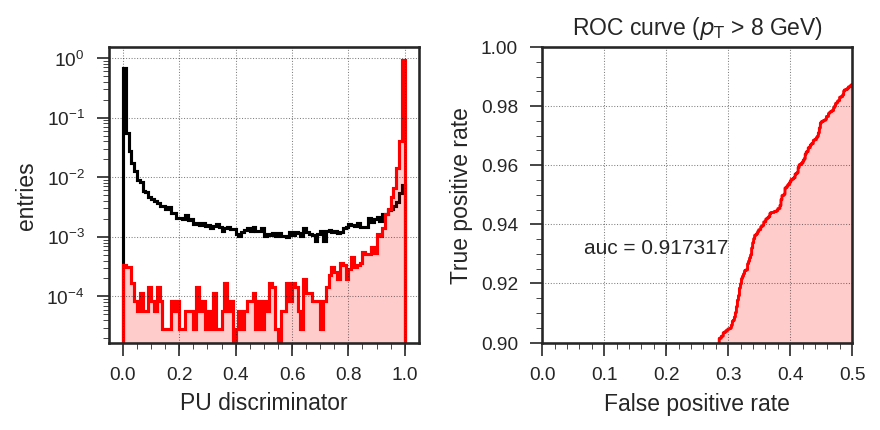

In [28]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
y_test_sel_med = np.abs(1.0/y_test_true) > discr_pt_cut_med
pu_y_test_sel_med = np.abs(1.0/pu_y_test_true) < discr_pt_cut_med

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_med], np.zeros_like(pu_y_test_true)[pu_y_test_sel_med]))
yy = np.concatenate((y_test_pred_discr[y_test_sel_med], pu_y_test_pred_discr[pu_y_test_sel_med]))
zz = np.concatenate((y_test_pred_regr[y_test_sel_med], pu_y_test_pred_regr[pu_y_test_sel_med]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_med
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_med)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (72088, 70265), ll: 0.218640131725, ss: 0.894572925172
[INFO    ] (3247, 66594), auc: 0.959331957636
[INFO    ] thr: [0.7709, 0.7068, 0.6241, 0.5446, 0.5189, 0.4941, 0.4634, 0.4179, 0.1345]
[INFO    ] tpr: [0.9002, 0.9252, 0.9500, 0.9701, 0.9750, 0.9800, 0.9850, 0.9900, 0.9990]
[INFO    ] fpr: [0.1370, 0.1820, 0.2507, 0.3357, 0.3625, 0.3930, 0.4352, 0.4863, 0.6908]


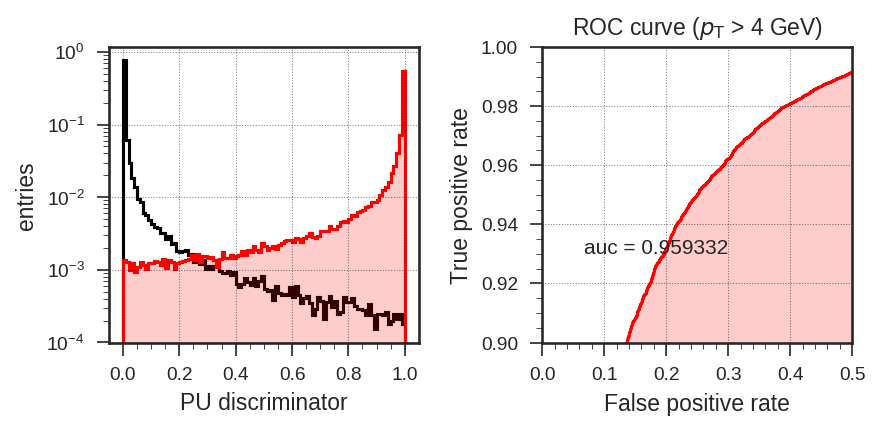

In [29]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 4 GeV, corresponding to 5 GeV trigger threshold
y_test_sel_low = np.abs(1.0/y_test_true) > discr_pt_cut_low
pu_y_test_sel_low = np.abs(1.0/pu_y_test_true) < discr_pt_cut_low

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_low], np.zeros_like(pu_y_test_true)[pu_y_test_sel_low]))
yy = np.concatenate((y_test_pred_discr[y_test_sel_low], pu_y_test_pred_discr[pu_y_test_sel_low]))
zz = np.concatenate((y_test_pred_regr[y_test_sel_low], pu_y_test_pred_regr[pu_y_test_sel_low]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_low
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_low)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Classification Results (2)

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (80628, 20086), ll: 0.0660080115263, ss: 0.96861429818
[INFO    ] (180, 18121), auc: 0.954363721649
[INFO    ] thr: [0.9906, 0.9874, 0.9823, 0.9729, 0.9698, 0.9650, 0.9566, 0.9453, 0.8639]
[INFO    ] tpr: [0.9013, 0.9282, 0.9504, 0.9721, 0.9756, 0.9805, 0.9856, 0.9907, 0.9990]
[INFO    ] fpr: [0.1556, 0.1944, 0.2611, 0.3000, 0.3222, 0.3500, 0.3722, 0.4278, 0.5556]


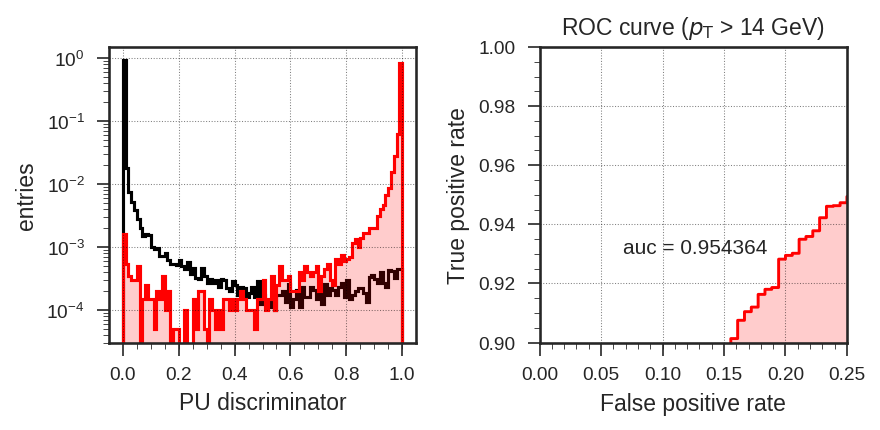

In [30]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
y_test_sel_high = np.abs(1.0/y_test_true) > discr_pt_cut_high
pu_y_test_sel_high = np.abs(1.0/pu_y_test_true) < discr_pt_cut_high

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_high], np.zeros_like(pu_y_test_true)[pu_y_test_sel_high]))
yy = np.concatenate((y_test_pred_discr1[y_test_sel_high], pu_y_test_pred_discr1[pu_y_test_sel_high]))
zz = np.concatenate((y_test_pred_regr[y_test_sel_high], pu_y_test_pred_regr[pu_y_test_sel_high]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_high)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.25)
axs[1].set_ylim(0.9,1.0)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (79866, 35286), ll: 0.201041967026, ss: 0.949617589343
[INFO    ] (613, 32726), auc: 0.94211765114
[INFO    ] thr: [0.7780, 0.7255, 0.6550, 0.5842, 0.5639, 0.5371, 0.5114, 0.4744, 0.3160]
[INFO    ] tpr: [0.9010, 0.9255, 0.9508, 0.9703, 0.9751, 0.9813, 0.9852, 0.9902, 0.9990]
[INFO    ] fpr: [0.2088, 0.2610, 0.3458, 0.4225, 0.4535, 0.4763, 0.4992, 0.5432, 0.6803]


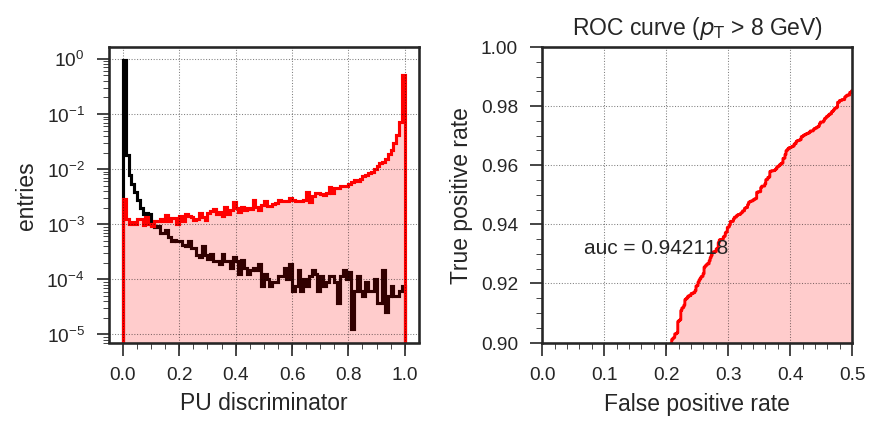

In [31]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
y_test_sel_med = np.abs(1.0/y_test_true) > discr_pt_cut_med
pu_y_test_sel_med = np.abs(1.0/pu_y_test_true) < discr_pt_cut_med

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_med], np.zeros_like(pu_y_test_true)[pu_y_test_sel_med]))
yy = np.concatenate((y_test_pred_discr1[y_test_sel_med], pu_y_test_pred_discr1[pu_y_test_sel_med]))
zz = np.concatenate((y_test_pred_regr[y_test_sel_med], pu_y_test_pred_regr[pu_y_test_sel_med]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_med
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_med)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (72088, 70265), ll: 2.4234014311, ss: 0.557817866252
[INFO    ] (3247, 66594), auc: 0.833018500637
[INFO    ] thr: [1.4960e-03, 8.5425e-04, 4.3315e-04, 2.0564e-04, 1.6391e-04, 1.2439e-04,
 8.9407e-05, 6.0290e-05, 1.0461e-05]
[INFO    ] tpr: [0.9001, 0.9251, 0.9500, 0.9700, 0.9750, 0.9800, 0.9850, 0.9900, 0.9991]
[INFO    ] fpr: [0.6600, 0.7521, 0.8334, 0.9018, 0.9187, 0.9329, 0.9476, 0.9615, 0.9954]


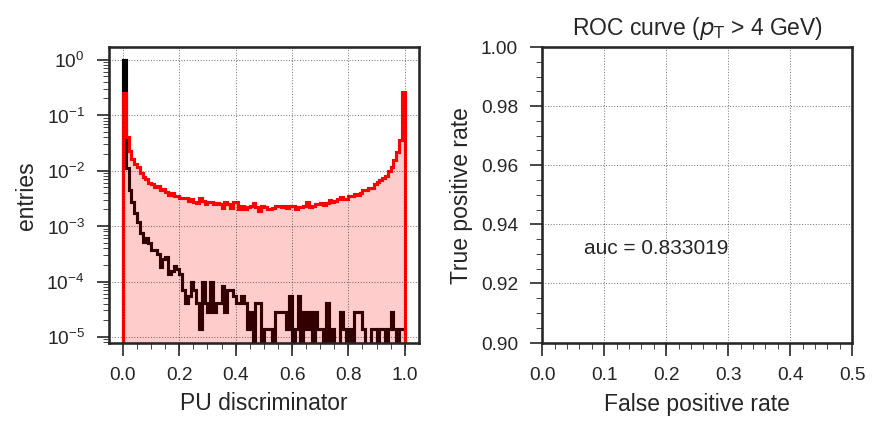

In [32]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 4 GeV, corresponding to 5 GeV trigger threshold
y_test_sel_low = np.abs(1.0/y_test_true) > discr_pt_cut_low
pu_y_test_sel_low = np.abs(1.0/pu_y_test_true) < discr_pt_cut_low

xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_low], np.zeros_like(pu_y_test_true)[pu_y_test_sel_low]))
yy = np.concatenate((y_test_pred_discr1[y_test_sel_low], pu_y_test_pred_discr1[pu_y_test_sel_low]))
zz = np.concatenate((y_test_pred_regr[y_test_sel_low], pu_y_test_pred_regr[pu_y_test_sel_low]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_low
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_low)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Regression Results &ndash; displaced muons pT

In [33]:
# Prepare d1_test_true, d1_test_pred
d1_test_true = get_true_pt(displ1_y_test[:nentries_test])
d1_test_pred = loaded_model.predict(displ1_x_test[:nentries_test], batch_size=4096)
d1_test_pred_regr = get_regr_pt(d1_test_pred[..., 1:2])
d1_test_pred_discr = get_discr(d1_test_pred[..., 5:6])
#print d1_test_true.shape, d1_test_true
#print d1_test_pred.shape, d1_test_pred

In [34]:
# Prepare pu_d1_test_true, pu_d1_test_pred
pu_d1_test_true = get_true_pt(pu_y_test)
pu_d1_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
pu_d1_test_pred_regr = get_regr_pt(pu_d1_test_pred[..., 1:2])
pu_d1_test_pred_discr = get_discr(pu_d1_test_pred[..., 5:6])
#print pu_d1_test_true.shape, pu_d1_test_true
#print pu_d1_test_pred.shape, pu_d1_test_pred

In [35]:
# Prepare d0_test_true, d0_test_pred
d0_test_true = get_true_dxy(displ1_dxy_test[:nentries_test])
d0_test_pred = d1_test_pred  # already predicted
d0_test_pred_regr = get_regr_dxy(d0_test_pred[..., 2:3])
#d0_test_pred_discr = get_discr(d0_test_pred[..., 5:6])
#print d0_test_true.shape, d0_test_true
#print d0_test_pred.shape, d0_test_pred

In [36]:
# Prepare pu_d0_test_true, pu_d0_test_pred
pu_d0_test_true = get_true_dxy(pu_dxy_test)
pu_d0_test_pred = pu_d1_test_pred  # already predicted
pu_d0_test_pred_regr = get_regr_dxy(pu_d0_test_pred[..., 2:3])
#pu_d0_test_pred_discr = get_discr(pu_d0_test_pred[..., 5:6])
#print pu_d0_test_true.shape, pu_d0_test_true
#print pu_d0_test_pred.shape, pu_d0_test_pred

[INFO    ] # of entries: 124468, mean: -5.209152e-03, std: 6.653628e-02, mse: 4.454211e-03, mae: 4.653173e-02, mad: 4.694029e-02
[INFO    ] gaus fit (a, mu, sig): 1.044865e+04, 1.181194e-03, 4.264122e-02
[INFO    ] # of entries: 23613, mean: 3.847505e-02, std: 4.657843e-02, mse: 4.759050e-03, mae: 4.500034e-02, mad: 3.823676e-02
[INFO    ] gaus fit (a, mu, sig): 9.145240e+02, 1.516189e-02, 2.909505e-02


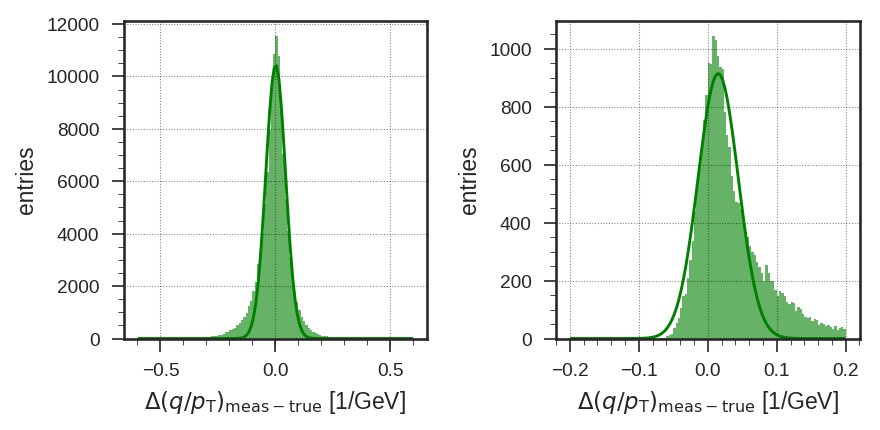

In [37]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = d1_test_true
yb = d1_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.6,0.6), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.6]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.6]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/d1_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.6/3,0.6/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.6/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.6/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 124468, mean: 2.044177e+00, std: 3.905938e-01, mse: 4.767772e+05, mae: 2.314861e+00, mad: 2.801235e-01
[INFO    ] gaus fit (a, mu, sig): 8.933312e+03, -7.214427e-04, 2.336008e-01
[INFO    ] # of entries: 23613, mean: 1.014070e+01, std: 4.906304e-01, mse: 2.513077e+06, mae: 1.098711e+01, mad: 7.844491e-01
[INFO    ] gaus fit (a, mu, sig): 1.079551e+03, -4.991252e-01, 4.076253e-01


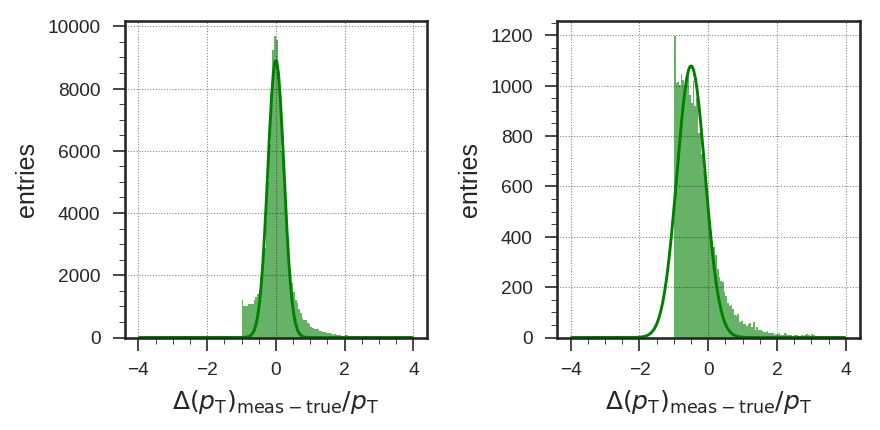

In [38]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(d1_test_true/d1_test_true)
yb = np.abs(d1_test_true/d1_test_pred_regr)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-4,4), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<1.5]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/d1_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-4,4), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<1.5]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

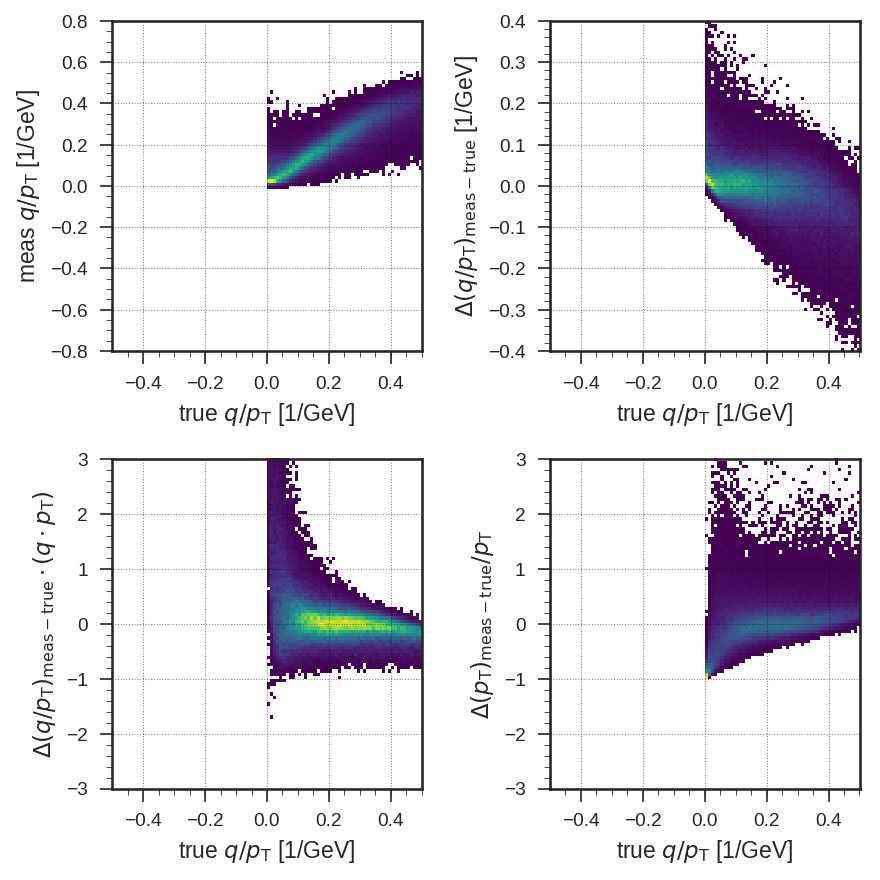

In [39]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = d1_test_true
yy = d1_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.8,0.8)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,0].set_ylabel(r'meas $q/p_{\mathrm{T}}$ [1/GeV]')

yy = d1_test_pred_regr - d1_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.4,0.4)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[0,1].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}}$ [1/GeV]')

yy = (d1_test_pred_regr - d1_test_true)/np.abs(d1_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,0].set_ylabel(r'$\Delta(q/p_{\mathrm{T}})_{\mathrm{meas-true}} \cdot (q \cdot p_{\mathrm{T}})$')

#yy = np.abs(d1_test_true/d1_test_pred_regr) - 1
yy = np.abs(d1_test_true)/np.abs(d1_test_pred_regr) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{\mathrm{T}}$ [1/GeV]')
axs[1,1].set_ylabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')

plt.show()

In [40]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(d1_test_true)
#yy = np.abs(d1_test_true/d1_test_pred_regr) - 1
yy = (d1_test_pred_regr - d1_test_true)/np.abs(d1_test_true)
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-4 <= yy_i) & (yy_i <= 4)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  #assert(np.abs(mu) < 1)
  #assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-4,4))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 5.876223e+01, 9.355129e-02, 5.003430e-01
[INFO    ] gaus fit (a, mu, sig): 4.451407e+01, 2.168877e-01, 7.074533e-01
[INFO    ] gaus fit (a, mu, sig): 3.908019e+01, 2.785726e-01, 7.286589e-01


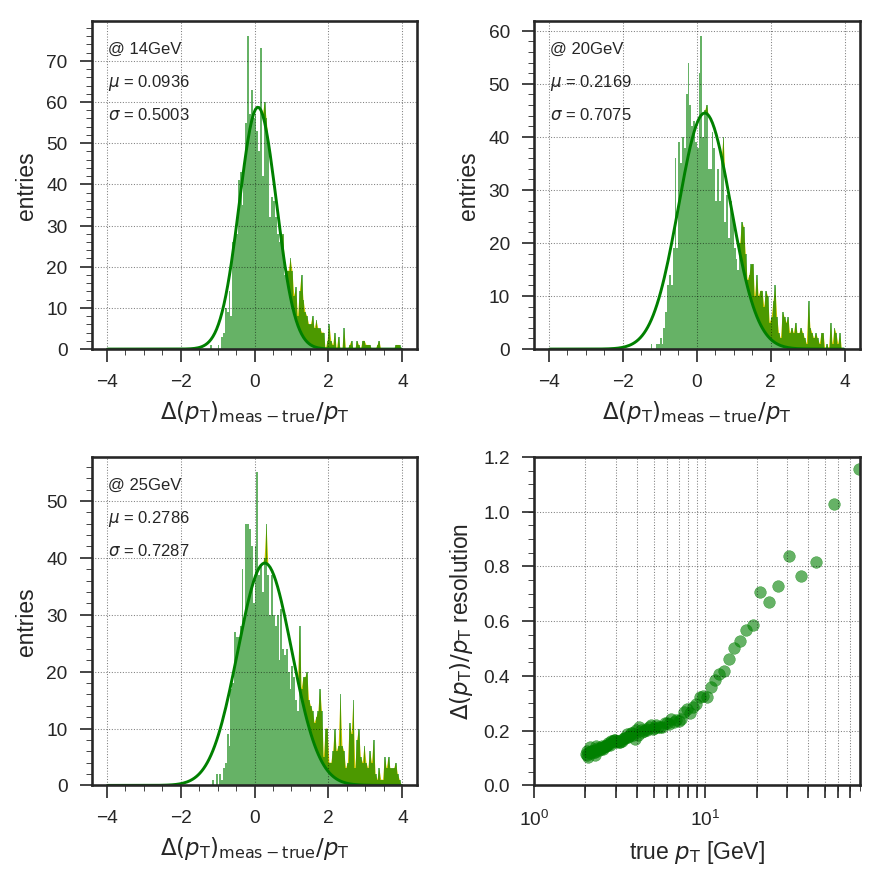

In [41]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-4,4), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,1.2)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(p_{\mathrm{T}}) / p_{\mathrm{T}}$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

In [42]:
# Quick efficiency
sel_100GeV = np.abs(1.0/d1_test_true) > 100.
denom = d1_test_true[sel_100GeV]
trig_50GeV = np.abs(1.0/d1_test_pred_regr) > 50.
numer = d1_test_true[sel_100GeV & trig_50GeV]
print 'L1 pT > 50 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100
trig_40GeV = np.abs(1.0/d1_test_pred_regr) > 40.
numer = d1_test_true[sel_100GeV & trig_40GeV]
print 'L1 pT > 40 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100
trig_30GeV = np.abs(1.0/d1_test_pred_regr) > 30.
numer = d1_test_true[sel_100GeV & trig_30GeV]
print 'L1 pT > 30 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100
trig_20GeV = np.abs(1.0/d1_test_pred_regr) > 20.
numer = d1_test_true[sel_100GeV & trig_20GeV]
print 'L1 pT > 20 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100
trig_10GeV = np.abs(1.0/d1_test_pred_regr) > 10.
numer = d1_test_true[sel_100GeV & trig_10GeV]
print 'L1 pT > 10 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100
trig_5GeV = np.abs(1.0/d1_test_pred_regr) > 5.
numer = d1_test_true[sel_100GeV & trig_5GeV]
print 'L1 pT > 5 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100
trig_0GeV = np.abs(1.0/d1_test_pred_regr) > 0.
numer = d1_test_true[sel_100GeV & trig_0GeV]
print 'L1 pT > 0 GeV', len(numer), len(denom), float(len(numer)) / float(len(denom)) * 100

L1 pT > 50 GeV 489 3377 14.4803079656
L1 pT > 40 GeV 798 3377 23.63044122
L1 pT > 30 GeV 1235 3377 36.5709209357
L1 pT > 20 GeV 1719 3377 50.9031684927
L1 pT > 10 GeV 2501 3377 74.0598164051
L1 pT > 5 GeV 3147 3377 93.1892212023
L1 pT > 0 GeV 3377 3377 100.0


### Regression Results &ndash; displaced muons d0

[INFO    ] # of entries: 124468, mean: 8.136946e-02, std: 1.332902e+01, mse: 1.983393e+02, mae: 9.837054e+00, mad: 1.016214e+01
[INFO    ] gaus fit (a, mu, sig): 4.838280e+03, 9.024860e-02, 9.329719e+00
[INFO    ] # of entries: 23613, mean: 1.073231e-01, std: 6.245451e+00, mse: 6.878593e+01, mae: 5.558132e+00, mad: 5.850292e+00
[INFO    ] gaus fit (a, mu, sig): 7.994771e+02, 1.229869e-01, 5.523467e+00


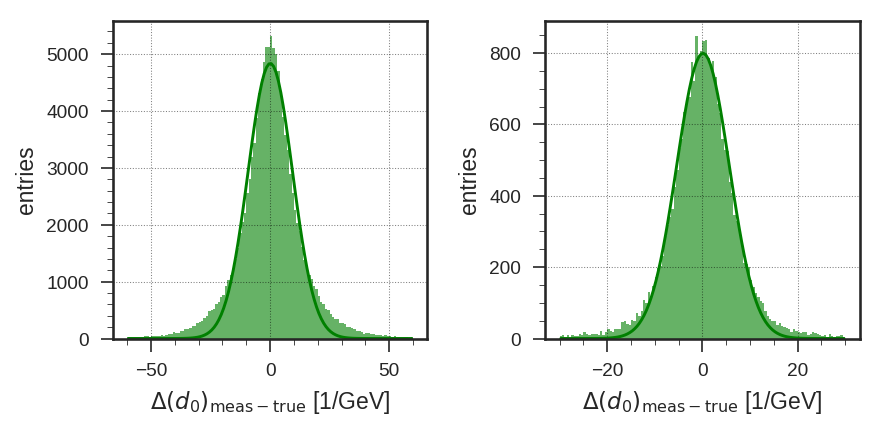

In [43]:
# Plot Delta(d0)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = d0_test_true
yb = d0_test_pred_regr
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-60,60), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<60]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<60]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

# Repeat with pT > 14 GeV
sel = (np.abs(1.0/d1_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-60/2,60/2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<60/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<60/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

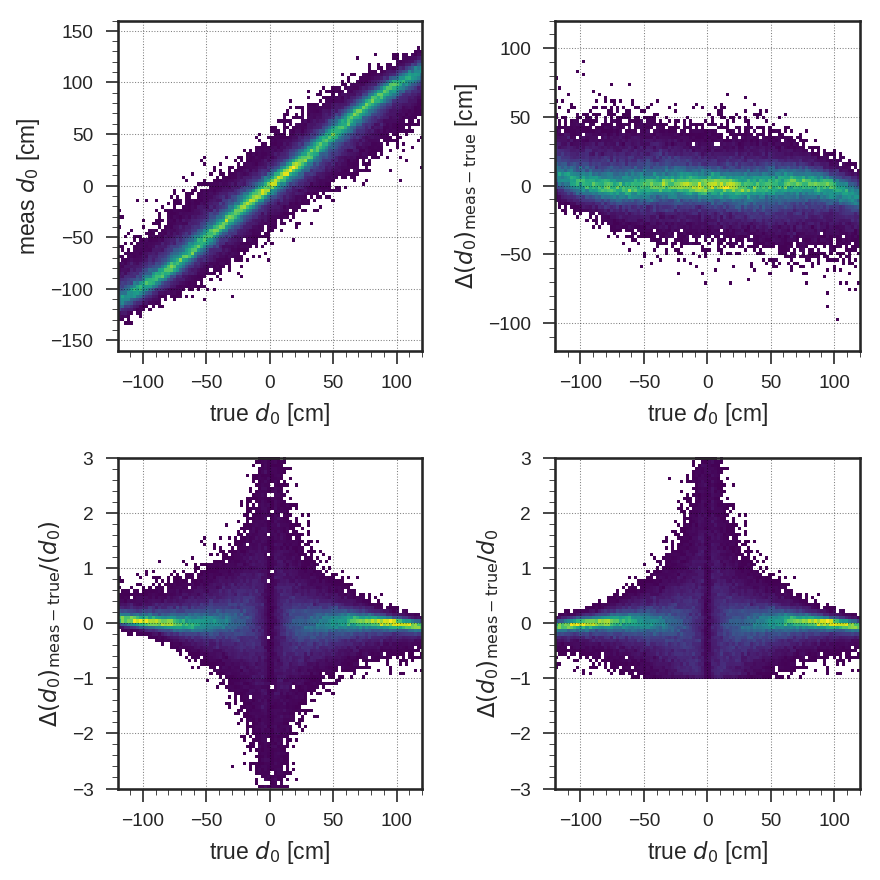

In [44]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = d0_test_true
yy = d0_test_pred_regr
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-160,160)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,0].set_ylabel(r'meas $d_{0}$ [cm]')

yy = d0_test_pred_regr - d0_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')

yy = (d0_test_pred_regr - d0_test_true)/np.abs(d0_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,0].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / (d_{0})$')

yy = np.abs(d0_test_pred_regr/d0_test_true) - 1
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / d_{0}$')

plt.show()

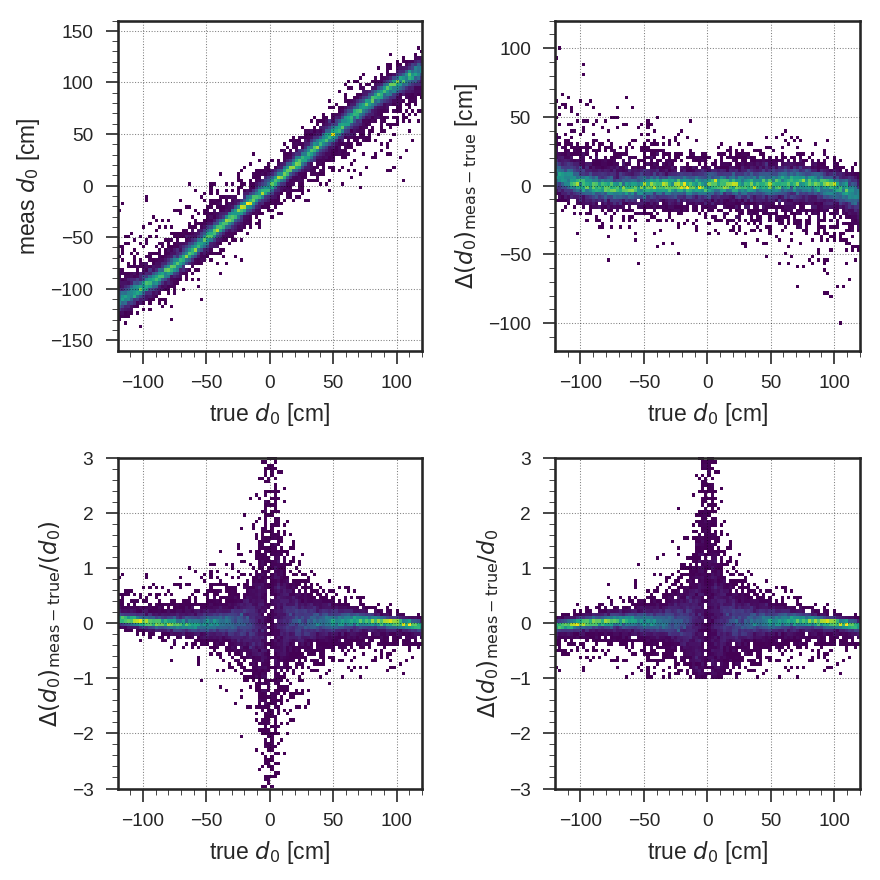

In [45]:
# Plot regression
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = d0_test_true[sel]
yy = d0_test_pred_regr[sel]
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-160,160)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,0].set_ylabel(r'meas $d_{0}$ [cm]')

yy = (d0_test_pred_regr - d0_test_true)[sel]
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-120,120)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[0,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')

yy = ((d0_test_pred_regr - d0_test_true)/np.abs(d0_test_true))[sel]
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,0].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / (d_{0})$')

yy = (np.abs(d0_test_pred_regr/d0_test_true) - 1)[sel]
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-120,120),(-3,3)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $d_{0}$ [cm]')
axs[1,1].set_ylabel(r'$\Delta(d_{0})_{\mathrm{meas-true}} / d_{0}$')

plt.show()

In [46]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(d1_test_true)
yy = (d0_test_pred_regr - d0_test_true)
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-60/2 <= yy_i) & (yy_i <= 60/2)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  #assert(np.abs(mu) < 1)
  #assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-60/2,60/2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=6)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 3.797196e+01, 2.361840e-01, 5.876441e+00
[INFO    ] gaus fit (a, mu, sig): 4.285410e+01, 7.140303e-02, 5.756943e+00
[INFO    ] gaus fit (a, mu, sig): 4.390541e+01, 3.655926e-02, 5.376261e+00


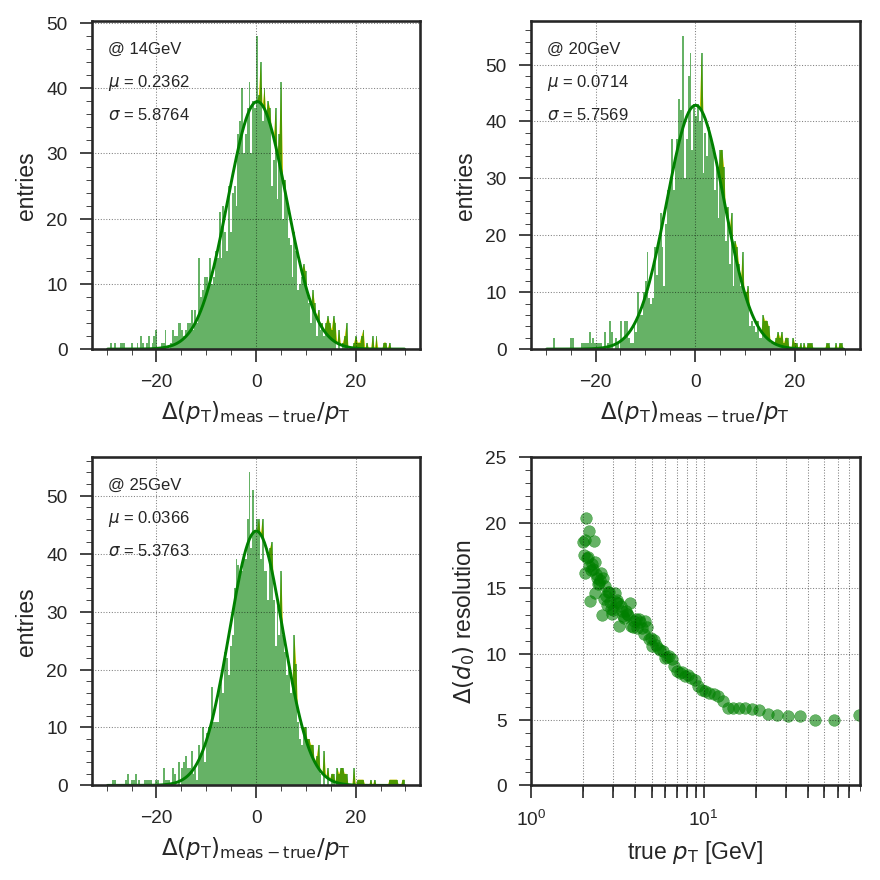

In [47]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-60/2,60/2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=6)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{\mathrm{T}})_{\mathrm{meas-true}} / p_{\mathrm{T}}$')
  ax.set_ylabel(r'entries')

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,80)
ax.set_ylim(0,25)
ax.set_xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'$\Delta(d_{0})$ resolution')
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,80,10)))

plt.show()

### Classification Results (3)

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
nn_plotting.py:63: RuntimeWarning: invalid value encountered in divide
  separation = (np.square(s - b)/(s + b)).sum()
[INFO    ] (80628, 23613), ll: 0.815447685576, ss: nan
[INFO    ] (190, 14041), auc: 0.853527826403
[INFO    ] thr: [0.5641, 0.5446, 0.5121, 0.4740, 0.4525, 0.4477, 0.4323, 0.4086, 0.2557]
[INFO    ] tpr: [0.9045, 0.9266, 0.9514, 0.9710, 0.9796, 0.9811, 0.9855, 0.9904, 0.9992]
[INFO    ] fpr: [0.4158, 0.4684, 0.5211, 0.5842, 0.6053, 0.6105, 0.6263, 0.6526, 0.8789]


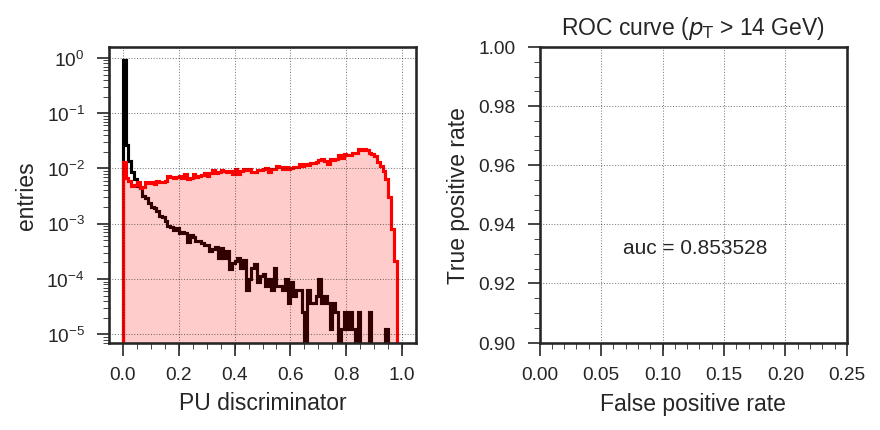

In [48]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
d1_test_sel_high = np.abs(1.0/d1_test_true) > discr_pt_cut_high
pu_d1_test_sel_high = np.abs(1.0/pu_d1_test_true) < discr_pt_cut_high

xx = np.concatenate((np.ones_like(d1_test_true)[d1_test_sel_high], np.zeros_like(pu_d1_test_true)[pu_d1_test_sel_high]))
yy = np.concatenate((d1_test_pred_discr[d1_test_sel_high], pu_d1_test_pred_discr[pu_d1_test_sel_high]))
zz = np.concatenate((d1_test_pred_regr[d1_test_sel_high], pu_d1_test_pred_regr[pu_d1_test_sel_high]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_high)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.25)
axs[1].set_ylim(0.9,1.0)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (79866, 41109), ll: 1.18750217645, ss: nan
[INFO    ] (850, 31703), auc: 0.824163940692
[INFO    ] thr: [0.2037, 0.1730, 0.1397, 0.1095, 0.1013, 0.0923, 0.0829, 0.0709, 0.0380]
[INFO    ] tpr: [0.9000, 0.9259, 0.9501, 0.9702, 0.9750, 0.9802, 0.9850, 0.9900, 0.9992]
[INFO    ] fpr: [0.5400, 0.5882, 0.6588, 0.7388, 0.7576, 0.7776, 0.8082, 0.8482, 0.9459]


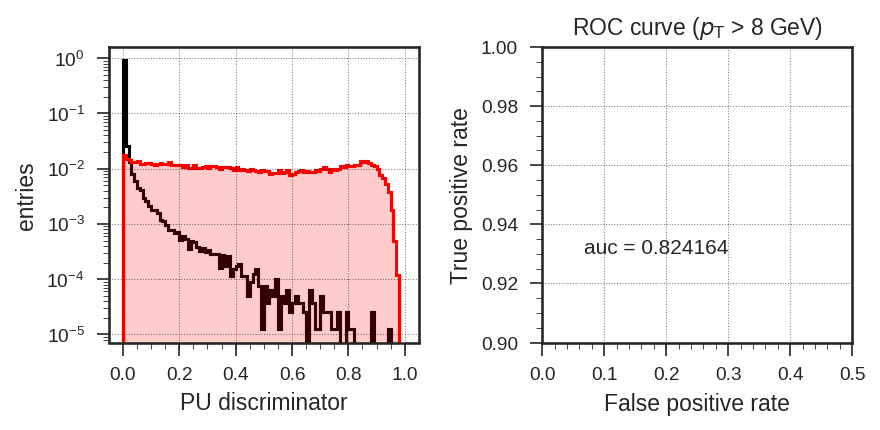

In [49]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
d1_test_sel_med = np.abs(1.0/d1_test_true) > discr_pt_cut_med
pu_d1_test_sel_med = np.abs(1.0/pu_d1_test_true) < discr_pt_cut_med

xx = np.concatenate((np.ones_like(d1_test_true)[d1_test_sel_med], np.zeros_like(pu_d1_test_true)[pu_d1_test_sel_med]))
yy = np.concatenate((d1_test_pred_discr[d1_test_sel_med], pu_d1_test_pred_discr[pu_d1_test_sel_med]))
zz = np.concatenate((d1_test_pred_regr[d1_test_sel_med], pu_d1_test_pred_regr[pu_d1_test_sel_med]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_med
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_med)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
[INFO    ] (72088, 79060), ll: 2.61252610561, ss: nan
[INFO    ] (5738, 73297), auc: 0.777340188775
[INFO    ] thr: [4.6172e-03, 2.9345e-03, 1.7213e-03, 9.0483e-04, 7.3904e-04, 5.7593e-04,
 4.2358e-04, 2.8336e-04, 3.4600e-05]
[INFO    ] tpr: [0.9001, 0.9251, 0.9500, 0.9701, 0.9750, 0.9800, 0.9850, 0.9901, 0.9990]
[INFO    ] fpr: [0.6391, 0.6765, 0.7295, 0.8010, 0.8224, 0.8470, 0.8712, 0.8977, 0.9841]


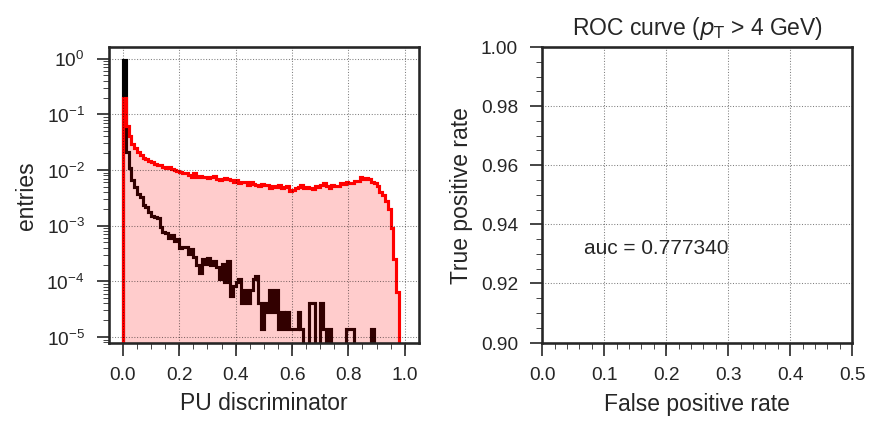

In [50]:
# Plot discriminator & ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

# pT > 4 GeV, corresponding to 5 GeV trigger threshold
d1_test_sel_low = np.abs(1.0/d1_test_true) > discr_pt_cut_low
pu_d1_test_sel_low = np.abs(1.0/pu_d1_test_true) < discr_pt_cut_low

xx = np.concatenate((np.ones_like(d1_test_true)[d1_test_sel_low], np.zeros_like(pu_d1_test_true)[pu_d1_test_sel_low]))
yy = np.concatenate((d1_test_pred_discr[d1_test_sel_low], pu_d1_test_pred_discr[pu_d1_test_sel_low]))
zz = np.concatenate((d1_test_pred_regr[d1_test_sel_low], pu_d1_test_pred_regr[pu_d1_test_sel_low]))

yy0 = yy[xx==0]
yy1 = yy[xx==1]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
ll = log_loss(np.zeros_like(yy0), yy0, labels=(0,1)) + log_loss(np.ones_like(yy1), yy1, labels=(0,1))  # (y_true, y_pred)
ss = separation_score(yy0, yy1)
logger.info('{0}, ll: {1}, ss: {2}'.format((len(yy0), len(yy1)), ll, ss))

zzz = np.abs(1.0/zz) > discr_pt_cut_low
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]
idx = np.searchsorted(tpr, working_points)
logger.info('{0}, auc: {1}'.format((len(yyy[xxx==0]), len(yyy[xxx==1])), auc))
logger.info('thr: {0}'.format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('tpr: {0}'.format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info('fpr: {0}'.format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{\mathrm{T}}$ > %.0f GeV)' % discr_pt_cut_low)
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.5)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Efficiency & Rates

In [51]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  lut = np.array([1,3,5,7,9,7,5,3,1,0,2,4,6,8,6,4,2,0], dtype=np.int32)
  return lut[ipt]

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

In [52]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut_low = 4.
    self.discr_pt_cut_med = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 2.4605,  2.0075,  1.9042,  2.0762,  2.4325,  2.9043,  3.4101,  3.9232,
                  4.4403,  4.9856,  5.5775,  6.2036,  6.8515,  7.5126,  8.1807,  8.8570,
                  9.5343, 10.2031, 10.8651, 11.5340, 12.2164, 12.9187, 13.6537, 14.4093,
                 15.1559, 15.8731, 16.5513, 17.2402, 17.9719, 18.7379, 19.5292, 20.3469,
                 21.1514, 21.9302, 22.6964, 23.4417, 24.1086, 24.7471, 25.4113, 26.1038,
                 26.7868, 27.4820, 28.2311, 29.0478, 29.9305, 30.8285, 31.6537, 32.3950,
                 33.1279, 33.8928, 34.6529, 35.4154, 36.2441, 37.1817, 38.2494, 39.2588,
                 40.1019, 40.8765, 41.6557, 42.4564, 43.2505, 44.0659, 44.9429, 45.8573,
                 46.7469, 47.6586, 48.6987, 49.6689, 50.3389, 50.9753, 51.7242, 52.4922,
                 53.2630, 54.0344, 54.8061, 55.5778, 56.3496, 57.1213, 57.8931, 58.6648,
                 59.4366, 60.2083, 60.9800, 61.7518, 62.5235, 63.2953, 64.0670, 64.8387,
                 65.6104, 66.3822, 67.1539, 67.9256, 68.6974, 69.4691, 70.2408, 71.0125,
                 71.7843, 72.5560, 73.3277, 74.0995, 74.8712, 75.6429, 76.4146, 77.1864,
                 77.9581, 78.7298, 79.5015, 80.2733, 81.0450, 81.8167, 82.5884, 83.3602,
                 84.1319, 84.9036, 85.6754, 86.4471, 87.2188, 87.9905, 88.7623, 89.5340]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      x = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      binx = x.astype(np.int32)
      if binx == bins[0]-1:  # avoid boundary
        binx -= 1
      return binx

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    trg_pt = interpolate(xml_pt, x0, x1, y0, y1)
    assert(trg_pt > 2.)
    return trg_pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_discr):
    ipt1 = strg.astype(np.int32)
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)
    strg_ok = (quality2 <= (quality1+1))

    xml_pt = np.abs(1.0/y_pred)

    # Apply cuts
    trigger = (y_discr < 0.)  # default: False
    if self.omtf_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.0% coverage)
        trigger = (y_discr > 0.6043)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.0% coverage)
        trigger = (y_discr > 0.2905)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (98.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    elif self.run2_input:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (97.0% coverage)
        trigger = (y_discr > 0.8557)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (97.0% coverage)
        trigger = (y_discr > 0.6640)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (97.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    else:
      if xml_pt > self.discr_pt_cut_high:  # >14 GeV (98.5% coverage)
        trigger = (y_discr > 0.9600)
      elif xml_pt > self.discr_pt_cut_med: # 8-14 GeV (98.5% coverage)
        trigger = (y_discr > 0.8932)
      elif xml_pt > self.discr_pt_cut_low: # 4-8 GeV (99.0% coverage)
        trigger = (y_discr > 0.2000)
      else:
        trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (4,))

      y_pred = np.asscalar(y[...,0])
      y_discr = np.asscalar(y[...,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, phi_median, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)

      if passed:
        xml_pt = np.abs(1.0/y_pred)
        pt = self.get_trigger_pt(y_pred)

        trk_q = np.sign(y_pred).astype(np.int32)
        trk = Track(myroad.id, myroad.hits, mode, myroad.quality, zone, xml_pt, pt, trk_q, y_pred, y_discr, phi_median, theta_median)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [53]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred_regr, y_test_pred_discr, y_test_true)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  true_pt = np.abs(1.0/y_true)
  
  eff_data.append((zone, true_pt, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(true_pt), float(xml_pt), float(pt), passed

eff_data = np.asarray(eff_data)

0 6 0.999725401402 26.4465675354 31.2348251343 45.3723482056 [ True]
1 6 0.893060445786 4.25680494308 6.02412223816 6.88339442329 [ True]
2 6 0.987689852715 12.298915863 8.68159484863 10.4435315796 [ True]
3 8 0.0141372382641 2.83806705475 3.09267902374 3.50520721416 [False]
4 7 7.08401203156e-05 2.08398747444 2.15505957603 2.57881421595 [ True]
5 8 0.033322840929 3.28855633736 3.07628560066 3.4883842834 [ True]
6 7 0.999991178513 204.229217529 143.917648315 219.82419841 [ True]
7 8 0.000152915716171 2.34633588791 2.329205513 2.74313832207 [ True]
8 7 0.0120080411434 3.22838068008 2.7380053997 3.14506626234 [ True]
9 4 0.132981210947 4.21332979202 3.35429334641 3.77367583208 [ True]
10 6 0.494375675917 4.78337335587 4.61455869675 5.12121458521 [ True]
11 8 0.0955612063408 3.92263269424 3.5311756134 3.95544181938 [False]
12 2 0.000668853521347 2.17857146263 2.15188193321 2.57581579218 [ True]
13 9 0.999733328819 16.017742157 13.7186231613 17.5601331343 [ True]
14 4 0.0123267173767 3.728

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


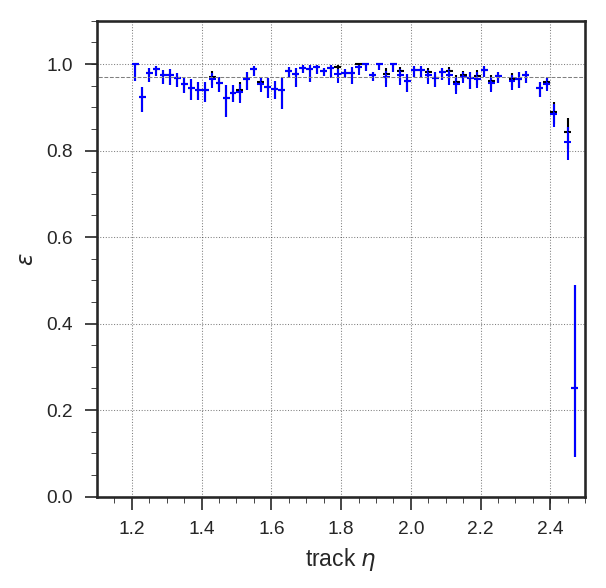

In [54]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is true_pt
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))

# Efficiency for (L1 pT > 20) only
color = 'black'
passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

# Efficiency for (L1 pT > 20 only && passed)
color = 'blue'
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1, fmt='o')

plt.plot([xlow-0.5,xup+0.5], [0.97,0.97], ls='dashed', lw=0.5, color='gray')
#plt.xlim(xlow-0.5,xup+0.5)
plt.xlim(1.1,2.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

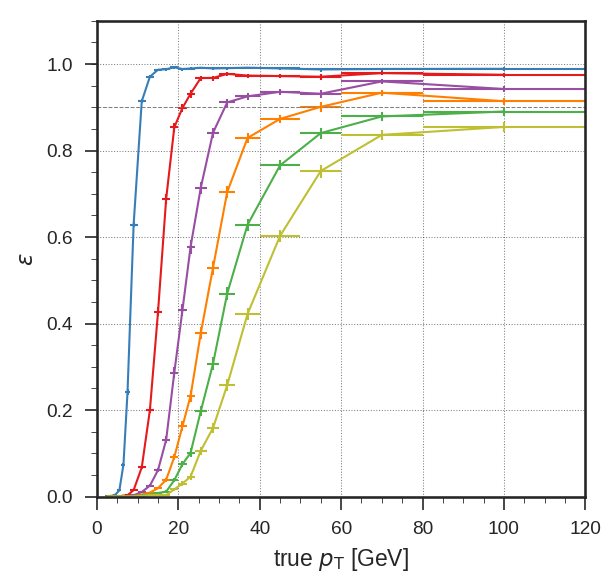

[INFO    ] Eff at 10/20/30/40/50/60 GeV: 0.913976066832, 0.898538961039, 0.911404335533, 0.873309608541, 0.840449438202, 0.836236933798


In [55]:
# Efficiency vs pT
plt.figure()

eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20.,
               22., 24., 27., 30., 34., 40., 50., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is true_pt

eff_hists = []

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is true_pt
  with np.errstate(divide='ignore', invalid='ignore'):
    eff_hist = np.true_divide(num_hist, denom_hist)
  eff_hists.append(eff_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  #print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='gray')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

logger.info("Eff at 10/20/30/40/50/60 GeV: {0}, {1}, {2}, {3}, {4}, {5}".format(
    eff_hists[0][11], eff_hists[1][16], eff_hists[2][20], eff_hists[3][22], eff_hists[4][23], eff_hists[5][24]))

In [56]:
# Find out pT scale factor

xmin = 0.
xmax = 60.
nbinsx = 120
xedges = np.linspace(xmin, xmax, num=nbinsx+1)  # edges used to digitize true_pt

nbinsy = 5  # j = zone0-1, zone2-4, zone5, zone6, all zones

# Each bin contains the threshold for ~90% probability for (zone_special, true_pt)
xxx = np.zeros((nbinsy,nbinsx), dtype=np.float32)

for j in xrange(nbinsy):
  if j == 0:
    sel_j = (0 <= eff_data[:,0]) & (eff_data[:,0] <= 1)
  elif j == 1:
    sel_j = (2 <= eff_data[:,0]) & (eff_data[:,0] <= 4)
  elif j == 2:
    sel_j = (eff_data[:,0] == 5)
  elif j == 3:
    sel_j = (eff_data[:,0] == 6)
  elif j == 4:
    sel_j = (eff_data[:,0] >= 0)

  xx = eff_data[:,1][sel_j]  # true_pt
  yy = eff_data[:,2][sel_j]  # xml_pt
  zz = eff_data[:,4][sel_j]  # discr_passed

  ind = np.digitize(xx, xedges[1:])  # split into mutually-exclusive true_pt bins

  for i in xrange(nbinsx):
    # >>> xedges[:5]
    # array([0. , 0.5, 1. , 1.5, 2. ])
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue

    if 0 <= xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 40:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size

    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90.
    coverage += 0.5 # inefficiency due to fiducial cuts
    #coverage += 1.0 # inefficiency due to fiducial cuts

    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue

    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    xxx[j,i] = pct

    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

14.0 0.293064148486
14.5 0.313588850174
15.0 0.332594235033
15.5 0.3885003885
16.0 0.423908435778
16.5 0.359874044085
17.0 0.285306704708
17.5 0.301053687908
18.0 0.365726227795
18.5 0.220507166483
19.0 0.296208530806
19.5 0.365853658537
20.0 0.320512820513
20.5 0.211267605634
21.0 0.218658892128
21.5 0.149700598802
22.0 0.0804505229284
22.5 0.16792611251
23.0 0.262237762238
23.5 0.271002710027
24.0 0.286806883365
24.5 0.395033860045
25.0 0.354400472534
25.5 0.3003003003
26.0 0.311720698254
26.5 0.254291163382
27.0 0.131061598952
27.5 0.138504155125
28.0 0.143266475645
28.5 0.293901542983
29.0 0.307455803228
29.5 0.394011032309
30.0 0.398089171975


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

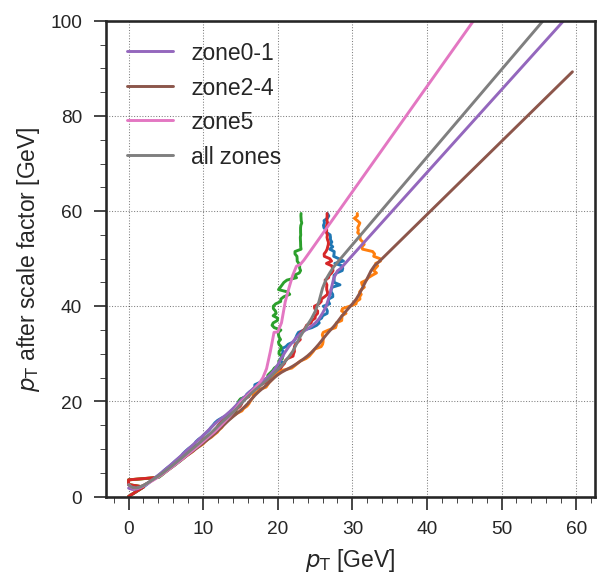

In [57]:
plt.figure()

# Before smoothing
xdata = xedges[:-1]
if omtf_input:
  #plt.plot(xxx[0], xdata)
  #plt.plot(xxx[1], xdata)
  #plt.plot(xxx[2], xdata)
  plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
else:
  plt.plot(xxx[0], xdata)
  plt.plot(xxx[1], xdata)
  plt.plot(xxx[2], xdata)
  #plt.plot(xxx[3], xdata)
  plt.plot(xxx[4], xdata)
plt.xlabel(r'$p_{\mathrm{T}}$ [GeV]')
plt.ylabel(r'$p_{\mathrm{T}}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xdata[:-16], smooth = 10.0, function='multiquadric')

# After smoothing
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if omtf_input:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')
else:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[4:]))

plt.ylim(0,100)
plt.show()

In [58]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for jevt, (x, x_mask, x_road, y_pred, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred_regr, pu_y_test_pred_discr, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, phi_median, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_discr)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(y_pred)
  #true_pt = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  highest_part_pt = highest_part_pt if highest_part_pt > 0 else np.nan
  highest_track_pt = highest_track_pt if highest_track_pt > 0 else np.nan
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  if passed and highest_part_pt < 14 and pt > 40.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt),
    print "{0} {1} {2}".format(ndof, pt, y_discr)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          if omtf_input:
            tmp = np.arange(2) * nlayers1 + lay
          else:
            if 0 <= lay <= 4:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1, 2 * nlayers1 + 6]) + lay
            elif lay == 11:
              tmp = np.array([0 * nlayers1, 1 * nlayers1, 2 * nlayers1 - 6, 2 * nlayers1]) + lay
            else:
              tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  33 1542 12.1225 28.0000 5 [42.03025535] [0.9991652]
  34  834 11.9378 21.0000 7 [44.44644274] [0.9947666]
  47 3847  3.2690 61.5000 6 [50.5938931] [0.9917385]
  48  955  4.3946 24.5000 5 [43.63040453] [0.9989892]
  54 6419  7.5854 41.5000 8 [43.03568672] [0.9998949]
  55 2596  7.9947 40.0000 8 [41.97241976] [0.99937725]
  59 3943 11.9290 21.5000 6 [54.45945555] [0.9994302]


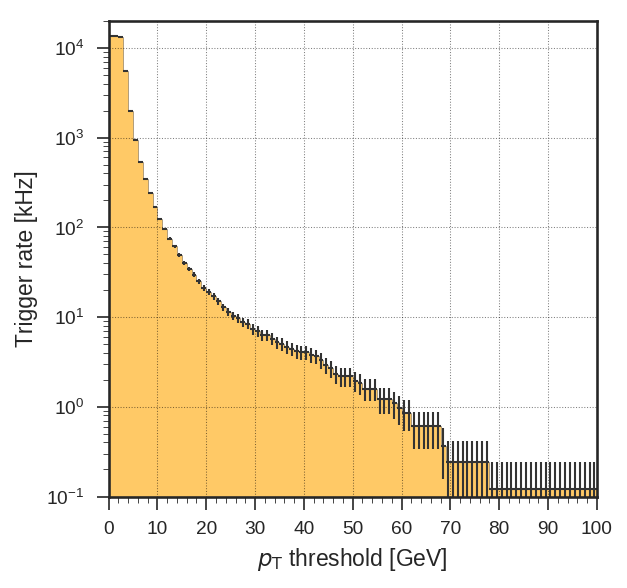

[INFO    ] nevents: 258400/498400
[INFO    ] Rates at 18/20/22/25/30 GeV: 25.0528155491, 19.064581506, 15.031689398, 10.3877527639, 6.96590476483


[1.3606e+04, 1.3606e+04, 1.3172e+04, 5.4989e+03, 1.9667e+03, 9.3038e+02,
 5.3344e+02, 3.4781e+02, 2.4173e+02, 1.6963e+02, 1.2355e+02, 9.5934e+01,
 7.5036e+01, 6.1227e+01, 4.9128e+01, 4.0451e+01, 3.4341e+01, 2.9697e+01,
 2.5053e+01, 2.1142e+01, 1.9065e+01, 1.6987e+01, 1.5032e+01, 1.2832e+01,
 1.1488e+01, 1.0388e+01, 9.7767e+00, 8.7990e+00, 8.4324e+00, 7.3325e+00,
 6.9659e+00, 6.3549e+00, 6.2327e+00, 5.7438e+00, 5.2550e+00, 5.0106e+00,
 4.6439e+00, 4.3995e+00, 4.1551e+00, 4.0329e+00, 4.0329e+00, 3.7885e+00,
 3.6663e+00, 3.2996e+00, 2.9330e+00, 2.6886e+00, 2.3220e+00, 2.1998e+00,
 2.1998e+00, 2.1998e+00, 1.9553e+00, 1.8331e+00, 1.5887e+00, 1.5887e+00,
 1.5887e+00, 1.2221e+00, 1.2221e+00, 1.2221e+00, 1.0999e+00, 9.7767e-01,
 8.5546e-01, 8.5546e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 3.6663e-01, 2.4442e-01, 2.4442e-01, 2.4442e-01,
 2.4442e-01, 2.4442e-01, 2.4442e-01, 2.4442e-01, 2.4442e-01, 2.4442e-01,
 1.2221e-01, 1.2221e-01, 1.2221e-01, 1.2221e-01, 1.

In [59]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808  # assume lumi=8e34, PU=200, xsec_pp=80mb
  nZeroBiasEvents = float(nevents)
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > 1e-7]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be approx half the statistics
logger.info("Rates at 18/20/22/25/30 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[20], hist[22], hist[25], hist[30]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

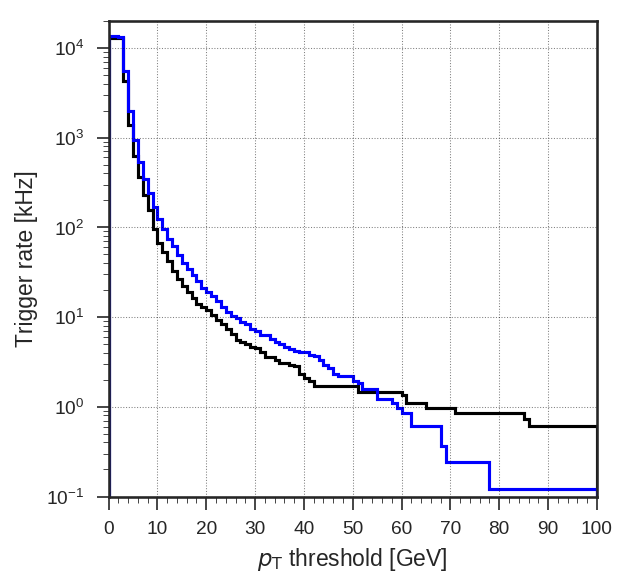

In [60]:
# Old rates
old_hist = [1.2879e+04, 1.2879e+04, 1.2879e+04, 4.2422e+03, 1.3642e+03, 6.1605e+02,
 3.6455e+02, 2.3159e+02, 1.5411e+02, 9.5812e+01, 6.6970e+01, 5.2672e+01,
 4.2162e+01, 3.2752e+01, 2.6397e+01, 2.1998e+01, 1.8820e+01, 1.6376e+01,
 1.4054e+01, 1.2954e+01, 1.1854e+01, 1.0632e+01, 9.1657e+00, 8.3102e+00,
 7.3325e+00, 6.4771e+00, 5.4994e+00, 5.2550e+00, 5.0106e+00, 4.6439e+00,
 4.5217e+00, 4.0329e+00, 3.5441e+00, 3.5441e+00, 3.2996e+00, 3.0552e+00,
 3.0552e+00, 2.9330e+00, 2.8108e+00, 2.3220e+00, 2.0776e+00, 1.9553e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.3443e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 1.0999e+00, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 9.7767e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01, 8.5546e-01,
 8.5546e-01, 7.3325e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='blue', lw=1.5)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

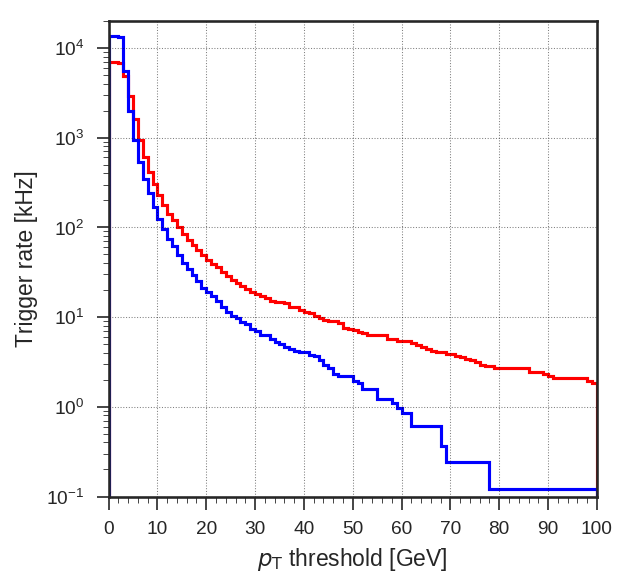

In [61]:
# Reference EMTF rates
old_hist = [7.0348e+03, 7.0348e+03, 6.7679e+03, 4.9052e+03, 2.8801e+03, 1.5997e+03,
 9.3649e+02, 6.0726e+02, 4.1551e+02, 3.0552e+02, 2.2865e+02, 1.7781e+02,
 1.4237e+02, 1.1940e+02, 9.9600e+01, 8.4569e+01, 7.1859e+01, 6.3182e+01,
 5.6338e+01, 4.9617e+01, 4.3262e+01, 3.9473e+01, 3.5929e+01, 3.2141e+01,
 2.8352e+01, 2.6153e+01, 2.4197e+01, 2.2242e+01, 2.0776e+01, 1.8820e+01,
 1.8209e+01, 1.7231e+01, 1.6254e+01, 1.5154e+01, 1.4665e+01, 1.4543e+01,
 1.4176e+01, 1.3076e+01, 1.2832e+01, 1.1854e+01, 1.1365e+01, 1.0999e+01,
 1.0143e+01, 9.7767e+00, 9.2879e+00, 9.0435e+00, 8.9212e+00, 8.6768e+00,
 7.5769e+00, 7.3325e+00, 7.2103e+00, 6.8437e+00, 6.7215e+00, 6.3549e+00,
 6.3549e+00, 6.2327e+00, 6.2327e+00, 5.7438e+00, 5.7438e+00, 5.3772e+00,
 5.3772e+00, 5.3772e+00, 5.1328e+00, 4.8884e+00, 4.6439e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 4.0329e+00, 3.9107e+00, 3.9107e+00, 3.6663e+00,
 3.5441e+00, 3.4218e+00, 3.2996e+00, 3.1774e+00, 2.9330e+00, 2.8108e+00,
 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.6886e+00,
 2.6886e+00, 2.6886e+00, 2.4442e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00,
 2.1998e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00, 2.0776e+00,
 2.0776e+00, 2.0776e+00, 1.9553e+00, 1.8331e+00]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='red', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='blue', lw=1.5)
plt.xlabel(r'$p_{\mathrm{T}}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.locator_params(axis='x', nbins=10)
plt.show()

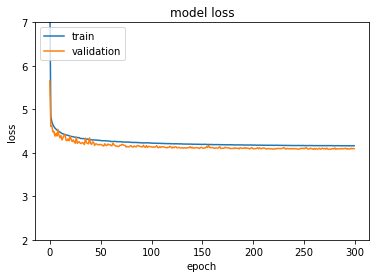

In [62]:
# Training history
# 2019-06-27

"""
[INFO    ] Done training. Time elapsed: 2:45:42.233456 sec
[INFO    ] Epoch 300/300 - loss: 4.16373185956 - regr_loss: 3.32120957551 - discr_loss: 0.0421261143613 - val_loss: 4.09427099966 - val_regr_loss: 3.26545494275 - val_discr_loss: 0.0414408028216
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3XmcFdWd9/HP7269NzTQ7MjiRssiICIGMSrGuMZdTNSJZhISJ4n6mkzmwewzT8zkmSRq4hgTTcyYxCUGQzSJ0YgBl6goICKrC4IsAs3SdDe93eU8f5zqpsFegdvLvd/368Wr71K36lQV91unTp0615xziIhI5gt1dwFERKRrKPBFRLKEAl9EJEso8EVEsoQCX0QkSyjwRUSyhAJfBDCz/zWz73Zw2g1mdvbhzkekqynwRUSyhAJfRCRLKPCl1wiaUr5qZm+aWbWZ3W9mg8zsr2ZWaWYLzKyk2fSfMLNVZlZhZovMrKzZe5PNbJmZVZnZ74Dcg5Z1oZktDz77kplNPMQyf87M3jGz3Wb2hJkNDV43M7vDzHYEZX/TzMYH751vZquDsm0xs387rA0nElDgS29zOXA2cDxwIfAU8DVgYPD/+SZ8aB4HPAzcApQCTwJ/MrOYmcWAPwK/AfoBvw/mS/DZycD9wOeB/sDPgSfMLKczBTWzs4D/Aq4ChgAbgUeCt88BTgeOA/oE0+wK3vsl8HnnXBEwHvj7kdyAkr0U+NLb3OWc2+6c2wK8ALzinHvdOVcHzAcmB9PNBv7inHvGORcHfgjkAR8BpgNR4E7nXNw5Nw94rdky5gA/d84tds4lnXMPAPXB5zrjGuB+59wy51w9cCtwqpmNAuJAETAWMOfcGufcB8Hn4sAJZlbsnNvjnFt2hLadZDkFvvQ225s9rm3heWHweGhQowbAOZcCNgHDgve2uANHDtzY7PFI4CtBc06FmVUAI4LPdcbBZagOavHDnHN/B/4HuBvYYWb3mllxMOnlwPnARjN7zsxO7eRyRVqkwJdMtTUIbgjazIPQ3gJ8AAwLXmt0VLPHm4DbnHN9m/3Ld849fJhlKAiaiLbgDwA/cc6dBJwQNO18NXj9NefcxUEz1R+BRw9jO4g0UeBLpnoUuMDMZplZFPhK0CzzEvAykABuMrOomV0GTGv22fuAL5jZKcHF1QIzu8DMijpZhoeBG8xsUtD+/z1gsXNug5mdHMw/CuwD6oBUcI3hGjPrEzRFVQKpI7xtJEsp8CUjOefWAdcCdwE7gYuAi5xzDc65BuAy4Hpgd9De/4dmn10CfC5octkDvBNM29kyLAC+CTwWnFUcDVwdvF0cHFj2BM0+u4AfBO9dB2wws0rgC8G1AJHDZvoBFBGR7KAavohIlkhb4JvZ8cGNK43/Ks3slnQtT0RE2tYlTTpmFg56JpzinNvYgY+IiMgR1lVNOrOAdxX2IiLdJ9JFy7k66KL2IWY2J7izkYKCgpPGjh3b6Zlv2LmPRMpxzMDCDkwtIpI5li5dutM5V9qRadPepBOMW7IVGOec297WtFOnTnVLlizp9DI+87+vUV5Vz5++fNrhFFVEpNcxs6XOuakdmbYrmnTOA5a1F/aHI2SQUvdSEZE2dUXgf7K15pwjxcxIKe9FRNqU1sAPxg75WPO7GNMhZKAbyERE2pbWi7bOuX3BYFGHLB6Ps3nzZurq6lqd5rqxURKpItasWXM4i8oKubm5DB8+nGg02t1FEZEu1lW9dA7Z5s2bKSoqYtSoURw4uOF+G3ftoy6e4vjBnR3bKrs459i1axebN29m9OjR3V0cEeliPX5ohbq6Ovr3799q2AO0/o40Z2b079+/zbMlEclcPT7wCYKqnSkAteF3RPvbUkQyVa8I/PaYKe5FRNqTEYEP6avgV1RU8NOf/rTTnzv//POpqKhIS5lERA5F5gR+mrQW+IlEos3PPfnkk/Tt2zeNJRMR6Zwe30unI9LZgj937lzeffddJk2aRDQaJTc3l5KSEtauXctbb73FJZdcwqZNm6irq+Pmm29mzpw5AIwaNYolS5ZQXV3Neeedx2mnncZLL73EsGHDePzxx8nLy0tTiUVEWtarAv8//rSK1VsrP/R6fSJFMuXIj4U7Pc8Thhbz7YvGtfr+97//fVauXMny5ctZtGgRF1xwAStXrmzq1nj//ffTr18/amtrOfnkk7n88svp3//AWw/efvttHn74Ye677z6uuuoqHnvsMa699tpOl1VE5HD0qsDvCaZNm3ZAH/af/OQnzJ8/H4BNmzbx9ttvfyjwR48ezaRJkwA46aST2LBhQxeXWkSklwV+azXxLXtq2Fub4IShxWkvQ0FBQdPjRYsWsWDBAl5++WXy8/M544wzWuzjnpOT0/Q4HA5TW1ub9nKKiBwsQy7apq9veVFREVVVVS2+t3fvXkpKSsjPz2ft2rW88soraSuHiMjh6lU1/FYZuDRdtu3fvz8zZsxg/Pjx5OXlMWjQoKb3zj33XH72s59RVlbG8ccfz/Tp09NSBhGRI6FLftO2o1r6AZQ1a9ZQVlbW5ue2VtSyp6aBcUP7pLmEmaEj21REeoee9gMoXaPnHLdERHqkjAh8jaQjItK+jAh8DZcpItK+zAh81fBFRNqVEYGvCr6ISPsyIvCDfpkiItKGDAn89PXD76zCwkIAtm7dyhVXXNHiNGeccQYHdz892J133klNTU3Tcw23LCKHKyMCv/FHnHrSPQVDhw5l3rx5h/z5gwNfwy2LyOHKiMBPp7lz53L33Xc3Pf/Od77Dd7/7XWbNmsWUKVOYMGECjz/++Ic+t2HDBsaPHw9AbW0tV199NWVlZVx66aUHjKVz4403MnXqVMaNG8e3v/1tCAZk27p1K2eeeSZnnnkmBMMt79y5E4Dbb7+d8ePHM378eO68886m5ZWVlfG5z32OcePGcc4552jMHhE5QO8aWuGvc2Hbmx96uSSZoiCRgpxw5y/hDp4A532/1bdnz57NLbfcwhe/+EUAHn30UZ5++mluuukmiouL2blzJ9OnT+cTn/hEq78Xe88995Cfn8+aNWtYsWIFU6ZMaXrvtttuo1+/fiSTSWbNmsWKFSu46aabuP3221m4cCEDBgw4YF5Lly7lV7/6FYsXL8Y5xymnnMJHP/pRSkpKNAyziLRJNfx2TJ48mR07drB161beeOMNSkpKGDx4MF/72teYOHEiZ599Nlu2bGH79u2tzuP5559vCt6JEycyceLEpvceffRRpkyZwuTJk1m1ahWrV69uszwvvvgil156KQUFBRQWFnLZZZfxwgsvgIZhFpF29K4afis18YqqOrbtrWP80D5Y6Mh30rzyyiuZN28e27ZtY/bs2Tz44IOUl5ezdOlSotEoo0aNanFY5Pa89957/PCHP+S1116jpKSE66+//pDm00jDMItIWzKiht8Y8em6ZDt79mweeeQR5s2bx5VXXsnevXsZOHAg0WiUhQsXsnHjxjY/f/rpp/PQQw8BsHLlSlasWAFAZWUlBQUF9OnTh+3bt/PXv/616TOtDcs8c+ZM/vjHP1JTU8O+ffuYP38+M2fOPOLrLCKZp3fV8FuV3luvxo0bR1VVFcOGDWPIkCFcc801XHTRRUyYMIGpU6cyduzYNj9/4403csMNN1BWVkZZWRknnXQSACeeeCKTJ09m7NixjBgxghkzZjR9Zs6cOZx77rkMHTqUhQsXNr0+ZcoUrr/+eqZNmwbAZz/7WSZPnqzmGxFpV0YMj1xeVc8He2sZN7SYcCgjTlrSSsMji2SOrBseualJp+ccu0REepyMCHwNpiMi0r5eEfjtNTul+6JtJulJTXgi0rV6fODn5uaya9cuBdUR4Jxj165d5ObmdndRRKQb9PheOsOHD2fz5s2Ul5e3Os2++gR7auKE9uYSTkM//EySm5vL8OHDu7sYItINenzgR6NRRo8e3eY0j7z6PnOfeJOXbz2LIX3yuqpoIiK9So9v0umIUDCGTUqtPiIirUpr4JtZXzObZ2ZrzWyNmZ2anuX4vyklvohIq9LdpPNj4Cnn3BVmFgPy07GQxhq+ruuKiLQubYFvZn2A04Hr8T1EGoCGdCyr8ebalBJfRKRV6WzSGQ2UA78ys9fN7BdmVnDwRGY2x8yWmNmStnritKWxhp9U4IuItCqdgR8BpgD3OOcmA/uAuQdP5Jy71zk31Tk3tbS09JAWtL9JR4EvItKadAb+ZmCzc25x8HxecAA44tRLR0SkfWkLfOfcNmCTmR0fvDQLaPvnnA5R471WasMXEWldunvpfBl4MOihsx64IR0Lafwt2VQqHXMXEckMaQ1859xyoEPjNB8O1fBFRNqXUXfaKu9FRFqXGYGvfvgiIu3KiMBvasNX4IuItCojAj+kwBcRaVdGBH5Y/fBFRNqVEYEf0miZIiLtyojAN9XwRUTalRGB31jD11g6IiKty4jAP+aFm7ks9Lxq+CIibciIwO+76e+Uhd5XLx0RkTZkROC7cJQoCQW+iEgbMiPwQ1FiCnwRkTZlTOBHSWi0TBGRNmRG4IejRCypGr6ISBsyIvAJxYI2/O4uiIhIz5URge/Cvg1f/fBFRFqXEYFPYxu+8l5EpFUZEfguHCWC2vBFRNqSEYFPOErM1C1TRKQtGRH4Lrhoq7wXEWldRgQ+wZ22STXii4i0KmMCX234IiJty5DAjwXdMru7ICIiPVeGBL4GTxMRaU9GBL6FokQtqX74IiJtyIjAd5EYEdXwRUTalBGBb01t+Ap8EZHWZETgE44RRU06IiJtiXR3AY4EC0fUpCMi0o7MqeFbkmRSv4AiItKajAh8C8f831Siu4siItJjZUbgR3zgk2zo7qKIiPRYmRH44aj/m4p3d1FERHqsjAh8Gmv4CnwRkValtZeOmW0AqoAkkHDOTU3LcoI2/JCadEREWtUV3TLPdM7tTOcCQhFdtBURaU9GNOk0tuGTUg1fRKQ16Q58Bywws6VmNqelCcxsjpktMbMl5eXlh7QQdcsUEWlfugP/NOfcJOA84ItmdvrBEzjn7nXOTXXOTS0tLT20pTQGvtrwRURaldbAd85tCf7uAOYD09KyIHXLFBFpV9oC38wKzKyo8TFwDrAyLQsLAj+kwBcRaVU6e+kMAuabWeNyHnLOPZWWJTW14SvwRURak7bAd86tB05M1/wPoBq+iEi7MqJbpmr4IiLty4zAD/kafl1dXXeXRESkx8qMwA+adLbvqe7ukoiI9FgZEvi+SWd3ZRUNCf0IiohISzIq8EMuwbvlquWLiLQkQwLfN+lESbB6a2V3l0ZEpEfKqMDPC6dYsbmiu0sjItIjZUjg+yadY/vn8NSqbSRTrrtLJCLS42RG4AfdMscNzmN7ZT2L39vV3SUSEelxMiTwQ2BhxpTEKIiFeWjx+91dIhGRHqdDgW9mN5tZsXm/NLNlZnZO+ovXCS5J9KXbuXvUC/x5xQes3LK3u0skItKjdLSG/xnnXGUw4mUJcB3w/TSXrXP6HQ3Aaakl9CuI8a3HV6otX0SkmY4GvgV/zwd+45xb1ey1nuELL8KEK4lUbuKbF5ax7P0Kfvbcu91dKhGRHqOjgb/UzP4WBP7TwTj3PeuW1lg+DDwBKrdwSVkRF04cwg+eXsfdC9+Bivehekd3l1BEpFt1dHjkfwYmAeudczVm1g+4Ic1l67zSsQBY+VvcMfskwiHjB0+v47JXv83Ao44j/MmHuruEIiLdpqM1/FOBdc65CjO7FvgG0POuipYe7/++9BOilZu4/apJfObU4fSvWc+utxazdpvuwhWR7NXRwL8HqDGzE4GvAO8Cv05z2TqvZJT/u+YJePprhEPGt04rJGZJBrqdfOquZ7jv+fWkdDFXRLJQRwM/4ZxzwMXA/zjn7gaK0ly2zguF4bJf+OvJW1+Hhn2wff/P6F41sprbnlzDJ+97hXd2aJA1EckuHW3DrzKzW4PumDPNLARE01y2QzPxSti3A57+Gtw9Hfbuvwnr/0xOMmbyRP7vn1dz9u3PMX5YMRdNGMJFE0oZ2r9PtxZbRCTdOlrDnw3UB/3xtwHDgR+kuWyHbthJ/m+zsCdWhJWv4apjYeHnj+UbF5QxKrWJKxaewTs/voBLf/oP/vuptbz0zk7iyZ7VAUlE5Egw31LTgQnNBgEnB09fdc4d8X6OU6dOdUuWLDn8GTXUwH8Nh1gh1AfXlkee5mv+LgUFA+GGJ+Gej8CO1QBcUfonlm+pJpFynFq4g0+PTZEz/iKOGVjI8JI8zHrWbQciIvhsXuqcm9qRaTvUpGNmVwU1+kXBDVd3mdlXnXPzDru06RDLh8nXwMBx0FDtL+Ym6uHxf/HvV7wPbz3tw37UTNjwAvNmD2Ff0WheeLuckiduYNKbrzF1STFV5DOwKIeTR/Xj7KKNTKxYwO6Z/8nI/gUU50XJjYa7e21FRDqko234XwdObqzVm1kpsADomYEP8Im7DnzeUANP3wp1eyHZAH/5iq/pz/oW/PJjsH0VBQOO5dxxg3F/fRdrSPDEOVW8mD+NpRt289qGPUyv/i1HRxbwydWnsoMS8mNhbj1vLGNKCxlQmIMZHJ23j/A/7oCz/wOiuVC5FR77HFz+Cyge0l1bQ0Skw4EfOqgJZ1evG2kzlg+X3Qe1FTB/DlRuhjO/DoMngIVg+yqo2QVvPYXt86s6esezjL76M1w3fSQAiV/+ADbBvecV8mZsHI8v38o3H191wGL+OefvfNN+wY83jmRZbCpzil9hxsYX2b78KQbOvF5NQyLSbToa+E+Z2dPAw8Hz2cCTaSxXehz3cf934XehajtM/QxE86DfGFj7F9i5DlIJP83I0+Dtv8HLd8OWZXDZvUR2vQXApNwdTDplFFdPO4pVWyupbUiys7qeeDLFkJfnQzmU7FnBe+EyVq1/hRkReOJvf+OOBUMYUZJPTTxB37wYg4pzyImEiYaNcUP7MLhPLvmxcNPj2oYkZqjZSESOiA4FvnPuq2Z2OTAjeOle59z89BYtjU7/qm/TLxjgnw8/Gd54GPL6Qe1u/9qFd8Dd03z3zsZpanb6xzvXARANh5g0ou+B8161C8rhn0bs5NpPnUHtr+6ETXDRoJ1sGTmCzXtqKMiJUFETZ0tFHQ2JJHXxFH9cvvWA2URCRiK4Qax/QYxoOER+TpjSwhyKciNMH9OfowcWEg2FMIMP9taRHwtz3KAiSgtzmoa2y4mEyImEdGYhIh3vpdMVjlgvnc5K1MO2lf4AULsH9m6Gsgvh99fD2ieheCjsec9Pa2EoGgJDJsKud+DTf4acQnj/FRhzJvx4Iuzd5A8e/74e7hgHlVv88y8tgSe+DP2PhjNu9c1MgfKqeipqGqisi7N80152VtdTlBvBOdi0u4ZkylHTkGRHVR17auKdunGsKCfCyAH5/jqDvwYT/AUwCnPCjB1STEl+lPpEirIhxWytqCU3GqYwJ0JhToQ+eVH65kcpyo0SDrV88HDO6cAi0sU600unzcA3syqgpQnMf79d8eEU9GDdFvitiddC1TYf9r+51L82dApsXQa5ffz7R58FiTpYvwhGTIdNr0Dfo3xPoBk3wz9+DMXD/TWDKZ+GZQ/4+Xz8e3DqFw+5aG9u3kttPEnR+8+SyOtP0ZhTqK5PsG5bFRW18abp6uJJdlTW8d6uGipqGnAOHM7/DfZsRU0DW/fWdWi5ZlCcG6VPXpRYJMSOyjr65EeprE1QXZ/gmNJCImEj5eDE4X2amqQaEinyY2H65scozo1Q05AkFgnRJy9KcW6U6voE+bEwQ/vmEYuEiCdTFOdGSaYcSefIj4XpX5BDNGxBOYxEMoWZtXoAEskGRyzwu1qPC/zmXroLVj8BU67ztfTPPw/rn4Nnvunfn3wtvP5b//jin8K6J2Htn/3zj86F54Lfizn2477G71KQVwJ1lfDRr8KA4/0ZxpZlMOREKBrkDyj3fxwmzobp/wILvwd9R8CwqdBvtO9t9MPj/Y+4f+EFKBnZctnL3/L3IIyc0Vit/5CKmgYqauIkneOdHdWMGVBAfSLFvnof5Htr41TUxKmojbO3poGK2ji1DUkGFedSVRenOC9KXjTM2zuqMSCecry+cQ850RC1DUlyomFqGhLUxQ/9prZwyAgZREIhomGjsi6BmW/yioRChEOGc45EynF0cOAJh4xIyPz7YSMaMsKhECnncM4xprSQvbVxImEjJxwiGg4RCvnPhc2Iho2BxbnEkylqGpLUNCRJJFMcN6iInGiIeNKRco4BBTlU1sUpyIkwoDBGOGTsqm6gICdCTUOC4twoRbkRDMNCEDIjFg4Ri3y470Nd3F+7yYno2o20T4GfbskEhIPLH7ve9eE94FjfBLRqPnxpKQw4BrYs9f39T/tXeP03sOA7cM3v4b0XYNH3IJrv7xEIbv5qEiuC0//NB/nTt/ofaT/5s7D4nv3TDDwBxl0KC2+DSK5vdrr6YRg4dv807y70TU2L7/HdUUec4s8yRp7qL1R3hHN+HfP7+X+N4rX+ovbxF/htkaiHSE67s6trSFBZn6AgFqEhkaKiNk5lbbwpGLdW1JFIpYiEjIqaONFwiEjY2FefZGtFLYmUoyGRIplK0Tc/hnOO8up6Ekl3wB3Sm/fUknSOZMqRSPq/8VSq6bkZxJMptlfWkxcNk3R+vp010rax0Q065N8Diob9waiRw1EXT/kDWzhEJGQMKvYX8+sTKT/wn/kDRmOzXCg4iOfHwvQriJFI+W0RMqNvfoydVfVU1cebmubyomGq6xPEk46xg4uoqvcdFULBvBr/RSNGNOS3vzVbP3fQSf+Awhycc1TWJXDOEQ0OnNGIL3/YLDiI7p+/P3gHB9bg9XCzaf1z/3rjgXZAYaxpXWvjSeriSUb1L6CqLkFuNIQDUs7v30TKH9DzYxHyY+HW6jkH6GgUlhblEA2HqI0nqWlIEDILrpX5Dhj1iRRmEAuHSKQc9YkUYTNyo/5amnOOhmSKaMhXLlIpR1V9gj55hzZajQK/u6SSPrwHT2jl/ZT/wfXyt+CeU+H8H8KJV8OS+yGnGKq3w4Dj/AXkdUEnqEET/HWFys2+hn7KF/w1ggX/Acl6GDQeLvgR/O46iNf4i8t9j/LXGJ78d3BJ6DMCTvk8vHKPP7uIFcHnnoWcIn+gePY/4R8/8cNLX/sYbHrVl+HMr/uzlsX3+K6rJ1wC02+EoZP9xexX7/X3G5SOhXk3wJX/6w8EBaX+LCWn8MD137zEl/Osb/gb42r3QE4fn1rxGn8AbOmb+fYC35tq1IwPv3fI+yqFM//lbOwF1Xh2kEz5WnvKNTaJ1ROLhMiPhX14YLzz/iZy96xj3NNXs2nat1h11DUU50WobUhSXlVPykG/gij76pPkx8LsrY1T25Aghf/Cp4IDzL6G5Id+irMoJ0I8maI+kSKedGyvrKM2niQ3GiJk5uPWEZyl+ABOOdhXn2D3vgZiER+48WSKyto4AwpzKM6LUl3nz9Rq4gmKcqKknOPtHdX0zYs2BVHSOVIpP794MkU8mUKDy3ac2f4DR/PHBB0xCnMj1MdT1MaTTa+lnGNgUS6vfG3WIS5Tgd/z1Vf5wG3Nhhdh+UO+Rj5kImxaDIMn7q9lb1/tu5KOnglHTYe9W+CPX4DKD/w1h1TCN/1c9WsoHAjhKCQa4IM34NcXQ3yfn0/j9YXjzvVnHvn9oeoDSO2/DsCJn/TNTUsfgPpKf8aRSkCswB/kcop8k1Eosr9bK/gL1aNm+LL2P8avU3yfv/5x/o/giS/5ayJ7NkDVVt+sNeo0GDoJjj3Hnx3t3Qwv/NCfRc24xY+IGor6Mq77Kxx1Clxyj593OApHz/JNXc75G98aOed/9ayh2h9gV/4BLr4LKjbBlH/y800l/b0YBaX7v62bX4N95f5aTTTPz+uN3/l7OfJK/EErrwQ+/Se/vrvXw7Apfts0t3kpPPYZvz9n/uv+1xvv/xg65cMHyPY457dLqFnTTzLh91Hzs7FGdZWQW3zQLJpdaHeuxQNuS8OJN06WcrCjqo5IKERxXoSQmT9QJBz1SX8wS6YcqRSk6qtJhsKkLNZ09pVKsf9xs7+Nr6dSjpxoiPxYhN376puWHwuHCYX8mVzf3BDJ2r0kc/oSMt+EFw37s6Z9DQlqGpId3qTtnQg4B9sq60gF15XyYhFwvhZfn0hRF0+SGw37M8pkqqnZLukc1XW+eTQSCtGvIEo8OCsNh3yzYeP9Pp2lwM92u971ITLspAPDoNGq+fDOs/5s4oPlvpY/6zuw8UV48Q4fYLO+BWv+7IP8rG9BJOYD462n/ZDTtbvhIzfBU3Nh48u+5v/Cj3zvo6GTYdsbsPMd3+wzaJwv01GnwOTr4OFP+rOT4uE+uAccB+Mvh/ULfW+p+oN+W2fgCTB8Kiw76CcYjj8/OBOy/X0L+h/r7262kD9wlK+DvL4QzoHtb+7/rIX92Q/BYHs1u32wN1T7M43iYf6Mp/E6TNEQOOFifx2nehvkD/DbZvJ18Obv/YX7Rv2PhfGXwVtP+YNAbh9Y8ydfxlDEnxXtec+H9ZJf+XJYyG+nukp/1vaRL/ttVLHJp+vav/htNfFqH+iFA+G95+HtZ2DCFUFPso1QvhY+WOGvKe1e77fbjJvh77fB4p/5A/tFd/qDm4Vg6a/8gXzilfDGI3DOd/3ylz+0/2z1mLP9gTjZ4A+A/Y6GPsP8ds4f4P9vJON+3dYv8uvpUlA4CIqGQvka//rin/vt+qnf+TPBeE1QGYn57ZeM+/GvEsFZYn2Vn0fj0aV2j9+fDdWwdTkMLPNleubbvnPFp5/wlZ/tq30T6vjLfflDET/90Mm+Z92AY/33Y9kDMOlaP781f4Ljz/PbpaDUX3ObOBtGTNu/X53zlZPcPv6s+Ogz/f9BzDdrJuP+/9XOt/w+LS2Djf+A3e/6M++S0b4ildvHN7VWb4fh03xlZ/BEX2E5BAp86R6Ntd327Nngw+rYc/yXpHDg/vZ/5/wBZc2fYdAJ/ktTWOqbfp6a6+ffb4wPmXGX+gDetBhGnw473/ZfsOJhPhx3veO/sHu3QF2Fnz5W6A+CfUf6UCse6r/4Iz/iQ71ktG/2Wr/Il+PUL8GYM+D5H/jljDnDf0mn3+ib1gZP9MsudownAAALYklEQVR67wUfHLFCWPRfPtAbm/Zqdvub/k7+LPzy49BQ5aeL1/hyn3IjbFnim7zCUXj37weeKYEPxcJBfpnNjZrpP5eo9U11LgX9x8C2N/2227nOB3sqAcd8zG+fRJ2frlFBqT/YRQv2n/mFc/yBuHytD6m+I/008Rr/fp+j/Gi0xcN8gG582Xczrt3Tyk43v+22LPNlSdTtP+BaeP9BovFAHIr65caK/IG3/9H+mtS+FsZsHDwB6qv9GdzAMl/mhqDbciTPH0i3LNlf5oEn+Glrdvp1r9l14PZoWnYhlF3km1vDUVj9uN/+jWUMx/af9RUP85WaWMH+e3maVypCUX921bDPN3duWnzgOhSUwlfWtVxBa4cCX+RwJRpg2wpf+29s3tm30zdtdeQKYH21//IfPG3FJh9ufUb42mlLF7q3r9pfk8zv7w+KOUX+M7W7/eO1f/GhNf1GX+Ovq4SiwUFohvxBqO9R8P5iH1SDx/umuW0r4PUHfYC6FBx1qp/uzd/7GvG6J/26jr3Ar2t9tW86W/aAD96jZ/kD6fuv+CD94A1/xjN0si/DUaf66UIR3xxXu8f3Hjtquj9Y734P/vYNf9Y1/GRf06/Z5dc7mufHvMop8mHcZ4Q/iO9Y44O6aKi/FhWO+gPdplf9wXnSNb5Z8oXb/TLz+8Hp/+7Xdc0TvvIw4Up/BjnuMv/jSEWD/NnOS3fBsR+DCVf5M9/Cgf7MbPwVsPIxXzuv2+u3w8iPQNkn/FnOyFP9GUvhIL9+Nbv9dty30/ekKxriz4AGnuCb+J6a6+fT/xi//UbN9NNVvO+3Y+O+PAQ9KvDNLAwsAbY45y5sa1oFvogcce1dL+uIlq5vtHLNo6t1JvC7YgC0m4E1XbAcEZEPO9ywh5aDvQeEfWelNfDNbDhwAfCLdC5HRETal+4a/p3AvwOt3tFiZnPMbImZLSkvL09zcUREslfaAt/MLgR2OOeWtjWdc+5e59xU59zU0tLSdBVHRCTrpbOGPwP4hJltAB4BzjKz36ZxeSIi0oa0Bb5z7lbn3HDn3CjgauDvzrlr07U8ERFpW+/6mUIRETlkHf2Jw8PinFsELOqKZYmISMtUwxcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXEckSCnwRkSyhwBcRyRIKfBGRLKHAFxHJEgp8EZEskbbAN7NcM3vVzN4wszVm9v10LUtERNoXSeO864GznHPVZhYFXjSzmc65F9K4TBERaUXaAt8554Dq4GkUCAN70rU8ERFpW1rb8M0sbGbLgR3AIufcyhammWNmS8xsSXl5eTqLIyKS1dIa+M65pHNuEjAcmGlmZ7Ywzb3OuanOuamlpaXpLI6ISFbrkl46zrkK4C/A1K5YnoiIfFg6e+mUmlnf4HEe8DFgebqWJyIibUtnL50hwANmFgoOLL91zj2TxuWJiEgb0tlLZwUwOV3zFxGRztGdtiIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIllCgS8ikiUU+CIiWUKBLyKSJRT4IiJZQoEvIpIlFPgiIlkibYFvZiPMbKGZrTazVWZ2c7qWJSIi7Yukcd4J4CvOuWVmVgQsNbNnnHOr07hMERFpRdpq+M65D5xzy4LHVcAaYFi6liciIm1LZw2/iZmNAiYDi1t4bw4wJ3habWbrDnExA4Cdh1fSHkPr0vNkynqgdemxDnVdRnZ0QnPOHcL8O87MCoHngNucc39I43KWOOempmv+XUnr0vNkynqgdemxumJd0tpLx8yiwGPAg+kMexERaV86e+kY8EtgjXPu9nQtR0REOiadNfwZwHXAWWa2PPh3fhqXd28a593VtC49T6asB1qXHivt65L2NnwREekZdKetiEiWUOCLiGSJXh/4Znauma0zs3fMbG53l6ezzGyDmb0ZXONYErzWz8yeMbO3g78l3V3OlpjZ/Wa2w8xWNnut1bKb2a3BflpnZh/vtoK3oJV1+Y6ZbWnpGlQPX5cWhzXpbfumjfXodfvFzHLN7FUze8PM1pjZ9+mOfeKc67X/gDDwLjAGiAFvACd0d7k6uQ4bgAEHvfbfwNzg8Vzg/3V3OVsp++nAFGBle2UHTgj2Tw4wOthv4e5eh3bW5TvAv7UwbU9flyHAlOBxEfBWUOZetW/aWI9et18AAwqDx9HgJtSZXb1PensNfxrwjnNuvXOuAXgEuLi7C3UEXAw8EDx+ALikm8vTIufc88Dug15urewXA4845+qdc+8B7wT7r0doZV1a09PXpbVhTXrVvjmE4Vl65Hrgy++cc9XB02hQWd3T1fuktwf+MGBTs+ebe+F4PQ5YYGZLg2EmAAY55z4IHm8DBnVj+TqrtbL31n31ZTNbETT5NJ5u95p1OWhYk167b1oYnqXX7RczC5vZcmAHsMg5t7Kr90lvD/xMcJpzbhJwHvBFMzu9+ZvOn9/1yr6zvbnsgXuC5sJJwAfAj7q7QJ0RDGvyGHCLc66y+Xu9ad+0sB69cr8455LBd304MNPMzjzo/bTvk94e+FuAEc2eDw9e6zWcc1uCvzuA+cFp23YzG4L/zz4kqBH0Fq2VvdftK+fc9uBLmgLua3ZK3ePXpZVhTXrdvmlpPXrzfsGXvwL4CzC1q/dJbw/814BjzWy0mcWAq4EnurtQHWVmBcFvBWBmBcA5wMpgHT4dTPZp4PHuLWmntFb2J4CrzSzHzEYDxwKvdmM529X4RQxcGuwbevq6tDGsSa/aN62tR2/cL2ZWamZ9g8d5wMeA5V2+T7r76vURuPp9fnD1/l3g691dnk6WfUxwJf4NYFVj+YH+wLPA28ACoF93l7WV8j8cnFLHgzbGf26r7MDXg/20Djivu8vfgXX5DfAmsCL4Ag7pJetyWtA0sCIIleXB96RX7Zs21qPX7RdgIvB68F1/E/g/rp3vejrWRUMriIhkid7epCMiIh2kwBcRyRIKfBGRLKHAFxHJEgp8EZEsocAXOQLM7Awz+3N3l0OkLQp8EZEsocCXrGJm1wbjki83s58HA1pVm9kdwZjrz5pZaTDtJDN7JRika37jIF1mdoyZLQjGNl9mZkcHsy80s3lmttbMHgzuFBXpMRT4kjXMrAyYDcwIBrFKAtcABcAS59w44Dng28FHfh3cETkxuDuy8fUHgbudcycCHwnu0CUYzfGWYCzzMcCMblpVkRZFursAIl1oFnAS8FpQ+c4LBqtKAb8Lpvkt8Acz6wP0dc49F7z+APD7YOyjYc65+fihSerwBxOAV51zm4Pny4FRwIvds6oiH6bAl2xiwAPOuVsPeNHsmwdNd6jjjdQ3e5zU90t6GjXpSDZ5FrjCzAay//dERwbfgyuCaT4FvOic2wvsMbOZwevXAc8Fv7y02cwuCeaRY2b53bZGIp2gGohkDefcajP7BvA3MwsFI2N+EdgHTAve2xG08xMMV/uzINDXAzcEr18H/NzM/jOYx5XduFoiHabRMiXrmVm1c66wu8shkm5q0hERyRKq4YuIZAnV8EVEsoQCX0QkSyjwRUSyhAJfRCRLKPBFRLLE/wf/RQw38l2MwwAAAABJRU5ErkJggg==")